Copyright (C) 2023 Pablo Castells y Alejandro Bellogín

El código que contine este notebook se ha implementado para la realización de las prácticas de la asignatura "Búsqueda y minería de información" de 4º del Grado en Ingeniería Informática, impartido en la Escuela Politécnica Superior de la Universidad Autónoma de Madrid. El fin del mismo, así como su uso, se ciñe a las actividades docentes de dicha asignatura.

### **Búsqueda y Minería de Información 2022-23**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Grado en Ingeniería Informática, 4º curso

# Bloque 2 - Análisis de redes sociales

Fechas:

* Comienzo: martes 28 / jueves 30 de marzo.
* Entrega: lunes 8 de mayo, 23:59.

## Objetivos

Este segundo bloque de la práctica tiene por objetivo la implementación de funcionalidades de análisis de redes sociales. En este bloque se desarrollarán:

* Métricas que se utilizan en el análisis de redes sociales.
* Otras funcionalidades a elección opcional del estudiante, tales como más métricas, la detección de comunidades, la generación aleatoria de redes sociales, o la recomendación de contactos.

## Material proporcionado

Se proporcionan software y datos para la realización de la práctica:

* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones. De modo similar a las prácticas anteriores, se proporciona una celda de prueba al final, que deberá funcionar con el código implementado por el estudiante.
* Redes sociales de prueba:
  - Tres redes pequeñas de prueba.
  - Redes reales: la red disponible en [SNAP (facebook_combined)](https://snap.stanford.edu/data/egonets-Facebook.html), y <ins>twitter.csv</ins> obtenida mediante una descarga de Twitter (unos 10 mil usuarios con medio millón de relaciones follow).
  - Al conjunto de redes de prueba, el estudiante añadirá dos redes más, simuladas, en el ejercicio 5.
  
Los esqueletos de código que se proporcionan aquí son a modo de guía: el estudiante puede modificarlo todo libremente, siempre que la celda de prueba funcione correctamente **sin cambios**.

## Calificación

El peso de esta práctica (recomendación + redes sociales) en la nota final de prácticas es del **40%**.

La calificación se basará en el **número** de ejercicios realizados y la **calidad** de los mismos. La puntuación que se indica en cada apartado es orientativa, en principio se aplicará tal cual se refleja pero podrá matizarse por criterios de buen sentido si se da el caso.

Para dar por válida la realización de un ejercicio, el código deberá funcionar (a la primera) integrado con las clases que se facilitan. El profesor comprobará este aspecto ejecutando la celda de prueba y otras adicionales.

La corrección de las implementaciones se observará por la **coherencia de los resultados**, y se valorará la eficiencia en tiempo de ejecución.

## Entrega

La entrega consistirá en dos ficheros tipo *notebook* (uno para recomendación y otro para redes sociales) donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

## Indicaciones

La realización de los ejercicios conducirá en muchos casos a la implementación de funciones y/o clases adicionales a las que se indican en el enunciado. Algunas vendrán dadas por su aparición en los propias celdas de prueba, y otras por conveniencia a criterio del estudiante.

Igual que en prácticas anteriores, no deberán editarse las celdas de prueba. Estas celdas deberán ejecutar sin errores a la primera con el código entregado por el estudiante (naturalmente con salvedad de los ejercicios que no se hayan implementado.

## Ejercicio 5: Preliminares (1.5pt)

Generar dos **redes sociales simuladas** siguiendo los modelos de Barabási-Albert y Erdös-Rényi. El tamaño y densidad de los grafos se deja a elección propia. Se puede utilizar para ello cualquier herramienta (como NetworkX, o el entorno interactivo de Gephi), o bien programar implementaciones propias (lo cual también es muy sencillo).

Realizar un análisis básico de la **distribución del grado** en las siete redes sociales de la práctica: small x 3, Facebook, Twitter, Barabási-Albert y Erdös-Rényi. Para cada red:

* Generar una gráfica de distribución del grado (utilizando escala log-log cuando ello sea útil) y comprobar en qué medida se observa una distribución power law.
* Verificar si se observa la paradoja de la amistad (en sus diferentes versiones).

Los resultados de este ejercicio no conllevan entrega de software, sino sólo la documentación de los mismos en el apartado de memoria.

In [1]:
# Si se ha implementado algún código, se puede incluir aquí
# Si no se ha utilizado Python, se puede utilizar el apartado de explicación siguiente para describir el proceso y las herramientas utilizadas

In [2]:
import pandas as pd
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [3]:
NETWORKS_PATH = 'networks'
ERDOS_FILENAME = 'erdos.csv'
BARABASI_FILENAME = 'barabasi.csv'

In [4]:
def matrix_to_df(matrix):
    """ Función que convierte una matriz de adyacencia en un dataframe de pandas con
    las conexiones entre nodos. Se asume que las conexiones son bidireccionales,
    por lo que solo se guardan las conexiones por encima de la diagonal.

    Args:
        matriz (numpy.ndarray): Matriz de adyacencia

    Returns:
        pandas.DataFrame: Dataframe de pandas
    """
    # Nos quedamos solo con la parte superior de la matriz, por encima de la diagonal
    # para evitar conexiones duplicadas
    matrix = np.triu(matrix, 1)

    # Convertimos la matriz de adyacencia en un dataframe de pandas
    df = pd.DataFrame(matrix)

    # Convertimos el dataframe en una lista de conexiones
    df = df.stack().reset_index()

    # Renombramos las columnas
    df.columns = ['u', 'v', 'peso']

    # Nos quedamos solo con las conexiones que tienen peso
    df = df[df['peso'] != 0]

    # Como todas las conexiones tienen el mismo peso, nos quedamos solo con las columnas u y v
    df = df[['u', 'v']].reset_index(drop=True)

    return df

In [5]:
def adjacency_matrix_from_df(df):
    """ Función que genera una matriz de adyacencia a partir de un dataframe de conexiones.

    Args:
        df (pandas.DataFrame): Dataframe de conexiones

    Returns:
        numpy.ndarray: Matriz de adyacencia
    """
    # Creamos la matriz de adyacencia a partir de las conexiones
    adjacency_matrix = pd.crosstab(df.u, df.v)
    idx = adjacency_matrix.columns.union(adjacency_matrix.index)
    adjacency_matrix = adjacency_matrix.reindex(index = idx, columns=idx, fill_value=0)

    # Lo convertimos a numpy array
    adjacency_matrix = adjacency_matrix.to_numpy()

    # Sumamos la transpuesta ya que todos los enlaces son bidireccionales
    adjacency_matrix = adjacency_matrix + adjacency_matrix.T

    # Todos los enlaces tienen el mismo peso, por lo que ponemos a 1 todos los valores mayores que 1
    adjacency_matrix[adjacency_matrix > 1] = 1

    # Eliminamos los enlaces de un nodo a sí mismo
    np.fill_diagonal(adjacency_matrix, 0)

    return adjacency_matrix

## Generación red Erdös-Rényi

In [6]:
# Generación Red Erdos-Renyi
def red_erdos_renyi(num_nodes, p):
    """ Función que genera una red aleatoria Erdos-Renyi con
    un número de nodos y una probabilidad de conexión dadas.

    Args:
        num_nodes (int): Número de nodos de la red
        p (float): Probabilidad de conexión entre nodos

    Returns:
        numpy.ndarray: Matriz de adyacencia de la red
    """
    m = np.random.choice([0, 1], size=(num_nodes, num_nodes), p=[1-p, p])

    # Nos quedamos solo con la parte superior de la matriz, por encima de la diagonal
    # y el resto de elementos los ponemos a 0. De esta forma, la probabilidad de 
    # conexión entre un par de nodos es p.
    m = np.triu(m, 1)

    # Sumamos la matriz con su traspuesta para obtener una matriz simétrica
    m = m + m.T

    return m

matriz_erdos = red_erdos_renyi(4000, 0.1)
df_erdos = matrix_to_df(matriz_erdos)

# Guardar red Erdos-Renyi
df_erdos.to_csv(os.path.join(NETWORKS_PATH, ERDOS_FILENAME), index=False, header=False)

print(matriz_erdos)
df_erdos

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,u,v
0,0,13
1,0,19
2,0,34
3,0,39
4,0,57
...,...,...
800841,3992,3994
800842,3992,3999
800843,3994,3997
800844,3994,3998


## Generación red Barabási-Albert

In [7]:
# Generación Red Barabasi-Albert
def red_barabasi_albert(num_nodes, m):
    """ Función que genera una red aleatoria Barabasi-Albert con
    un número de nodos y un número de conexiones por nodo dadas.

    Args:
        num_nodes (int): Número de nodos de la red
        m (int): Número de conexiones por nodo nuevo que se añade a la red

    Returns:
        numpy.ndarray: Matriz de adyacencia de la red
    """
    # Creamos una lista de nodos inicial
    nodes = list(range(m))

    # Lista de conexiones. Cada elemento es una tupla con los nodos conectados
    edges = []

    # Lista donde cada nodo aparece por lo menos una vez, y luego
    # aparece tantas veces como conexiones tenga

    choice_list = [node for node in nodes for _ in range(m)]

    # Conectamos aleatoriamente algunos nodos de la lista inicial
    for node1 in nodes:
        for node2 in nodes:
            # No conectamos un nodo consigo mismo
            if node1 == node2:
                continue

            # Probabilidad de conexion es 0.5
            if random.random() < 0.5:
                edges.append((node1, node2))
                choice_list.append(node1)
                choice_list.append(node2)

    # Añadimos el resto de nodos
    for node in range(m, num_nodes):
        # Elegimos m nodos de la lista de nodos con repetición
        new_edges = set(random.choices(choice_list, k=m))

        # Si no se han elegido m nodos únicos, es decir, han salido repetidos,
        # elegimos nodos hasta que tengamos m nodos únicos
        while len(new_edges) < m:
            new_edges.add(random.choice(choice_list))

        # Conectamos el nodo con los m nodos elegidos
        for node2 in new_edges:
            edges.append((node, node2))
            choice_list.append(node)
            choice_list.append(node2)

        nodes.append(node)

    # Creamos la matriz de adyacencia
    m = np.zeros((num_nodes, num_nodes))

    # Añadimos las conexiones a la matriz de adyacencia
    for node1, node2 in edges:
        m[node1, node2] = 1
        m[node2, node1] = 1

    return m

matriz_barabasi = red_barabasi_albert(4000, 10)
df_barabasi = matrix_to_df(matriz_barabasi)

# Guardar red Barabasi-Albert sin header
df_barabasi.to_csv(os.path.join(NETWORKS_PATH, BARABASI_FILENAME), index=False, header=False)

print(matriz_barabasi)
df_barabasi

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,u,v
0,0,1
1,0,2
2,0,4
3,0,5
4,0,6
...,...,...
39931,3884,3955
39932,3936,3959
39933,3938,3981
39934,3942,3944


## Análisis de la distribución del grado

In [8]:
def degree_frequency(adjacency_matrix):
    """ Función que calcula la frecuencia de los grados de una red.

    Args:
        adjacency_matrix (numpy.ndarray): Matriz de adyacencia

    Returns:
        numpy.ndarray: Array con los grados entre el mínimo y el máximo de la red
        numpy.ndarray: Array con el número de nodos que tiene cada grado.
                       Tiene el mismo tamaño que el array anterior.
    """
    # Suma por filas para obtener el grado de cada nodo
    nodes_degrees = adjacency_matrix.sum(axis=1)

    # Contamos cuántos nodos hay de cada grado
    degrees = np.arange(nodes_degrees.min(), nodes_degrees.max() + 1)
    degrees_count = np.zeros(degrees.shape)
    for degree in degrees:
        degrees_count[degree - degrees.min()] = np.count_nonzero(nodes_degrees == degree)

    return degrees, degrees_count

In [9]:
def plot_frecuencia_grados(adjacency_matrix, log=False):
    """ Función que pinta una gráfica con la frecuencia de los grados de una red.

    Args:
        adjacency_matrix (numpy.ndarray): Matriz de adyacencia
        log (bool, optional): Si es True, pinta la gráfica en escala logarítmica.
                              Por defecto es False.
    """
    # Calculamos la frecuencia de los grados
    degrees, degrees_count = degree_frequency(adjacency_matrix)

    # Plot de la distribución de grados
    plt.figure(figsize=(10, 6))

    if log:
        plt.loglog(degrees, degrees_count, '.')
    else:
        plt.plot(degrees, degrees_count, '.')

    plt.xlabel('Grado')
    plt.ylabel('Número de nodos')
    plt.title(f'Frecuencia de grados (log = {log})')
    plt.show()

In [10]:
def plot_grados_ordenados(adjacency_matrix, log = False):
    """ Función que pinta una gráfica con los grados de los nodos ordenados de mayor a menor.

    Args:
        adjacency_matrix (numpy.ndarray): Matriz de adyacencia
        log (bool, optional): Si es True, pinta la gráfica en escala logarítmica.
                              Por defecto es False.
    """
    # Calculamos los grados de los nodos
    nodes_degrees = adjacency_matrix.sum(axis=1)

    # Ordenamos los grados de mayor a menor
    nodes_degrees = np.sort(nodes_degrees)[::-1]

    # Plot de los grados ordenados. En el eje x está el nodo y en el eje y el grado
    plt.figure(figsize=(10, 6))

    if log:
        plt.loglog(np.arange(nodes_degrees.shape[0]), nodes_degrees, '.')
    else:
        plt.plot(np.arange(nodes_degrees.shape[0]), nodes_degrees, '.')

    plt.xlabel('Nodo')
    plt.ylabel('Grado')
    plt.title(f'Grados ordenados (log = {log})')
    plt.show()

### Análisis red toy1.csv

In [11]:
# Cargamos los datos de las conexiones de la red a un dataframe
red_filename = 'toy1.csv'

file = os.path.join('networks', red_filename)
df = pd.read_csv(file, names=['u', 'v'], delimiter=',')

# Creamos la matriz de adyacencia a partir de las conexiones
adjacency_matrix = adjacency_matrix_from_df(df)

Distribución de la frecuencia de los grados

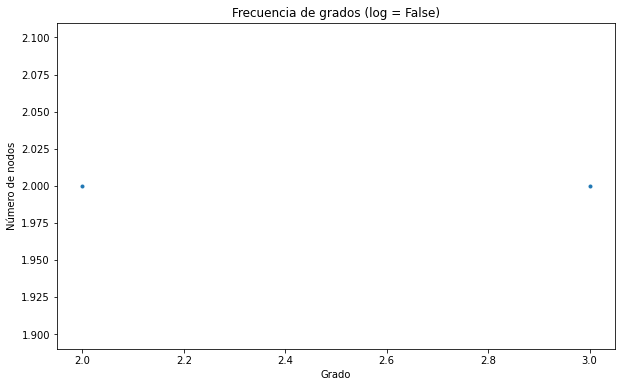

In [12]:
# Pintamos la distribución de la frecuencia de los grados
plot_frecuencia_grados(adjacency_matrix, log=False)

En esta primera red, al ser muy pequeña, no se observa ninguna distribución. Solo vemos que hay dos nodos con grado 2 y otros dos con grado 3.

Grados ordenados

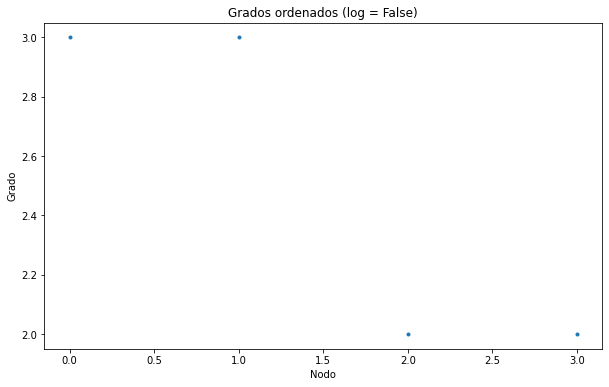

In [13]:
plot_grados_ordenados(adjacency_matrix, log=False)

Al mirar los grados ordenados, observamos al igual que antes, que hay dos nodos con grado 3 y otros dos con grado 2.

### Análisis red toy2.csv

In [14]:
# Cargamos los datos de las conexiones de la red a un dataframe
red_filename = 'toy2.csv'

file = os.path.join('networks', red_filename)
df = pd.read_csv(file, names=['u', 'v'], delimiter=',')

# Creamos la matriz de adyacencia a partir de las conexiones
adjacency_matrix = adjacency_matrix_from_df(df)

Distribución de la frecuencia de los grados

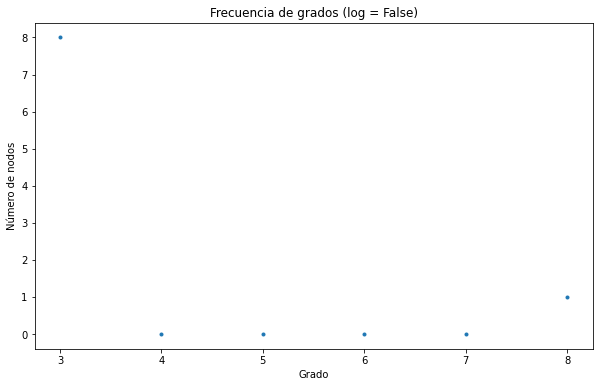

In [15]:
# Pintamos la distribución de la frecuencia de los grados
plot_frecuencia_grados(adjacency_matrix, log=False)

En esta red solo se puede observar que casi todos los nodos tienen grado 3, mientras que hay uno con grado 8.

Grados ordenados

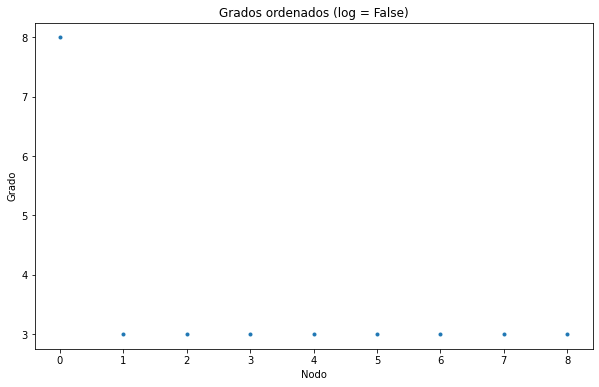

In [16]:
plot_grados_ordenados(adjacency_matrix, log=False)

Vemos, al igual que antes, que hay un nodo con grado 8 y el resto tienen grado 3.

### Análisis red toy3.csv

In [17]:
# Cargamos los datos de las conexiones de la red a un dataframe
red_filename = 'toy3.csv'

file = os.path.join('networks', red_filename)
df = pd.read_csv(file, names=['u', 'v'], delimiter=',')

# Creamos la matriz de adyacencia a partir de las conexiones
adjacency_matrix = adjacency_matrix_from_df(df)

Distribución de la frecuencia de los grados

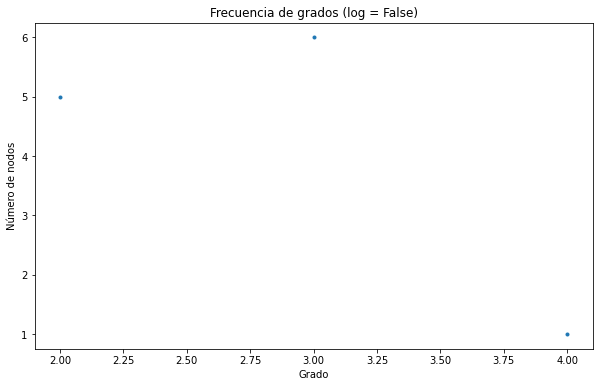

In [18]:
# Pintamos la distribución de la frecuencia de los grados
plot_frecuencia_grados(adjacency_matrix, log=False)

Para la red toy3 vemos que hay 5 nodos con grado 2, 6 con grado 3 y 1 con grado 4.

Grados ordenados

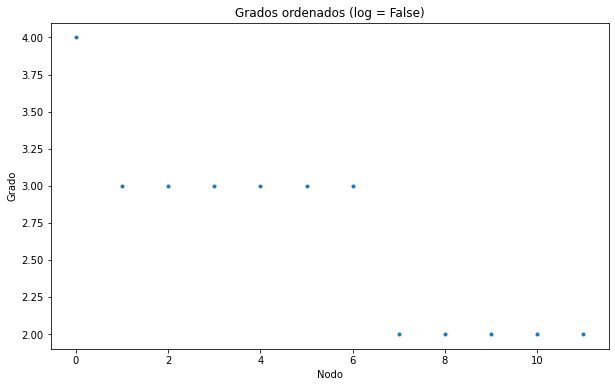

In [19]:
plot_grados_ordenados(adjacency_matrix, log=False)

Vemos exactamente lo mismo que antes, 5 nodos con grado 2, 6 con grado 3 y 1 con grado 4.

### Análisis red twitter.csv

In [20]:
# Cargamos los datos de las conexiones de la red a un dataframe
red_filename = 'twitter.csv'

file = os.path.join('networks', red_filename)
df = pd.read_csv(file, names=['u', 'v'], delimiter=',')

# Creamos la matriz de adyacencia a partir de las conexiones
adjacency_matrix = adjacency_matrix_from_df(df)

Distribución de la frecuencia de los grados

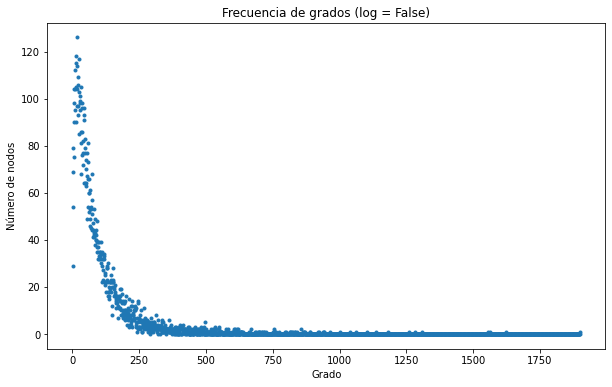

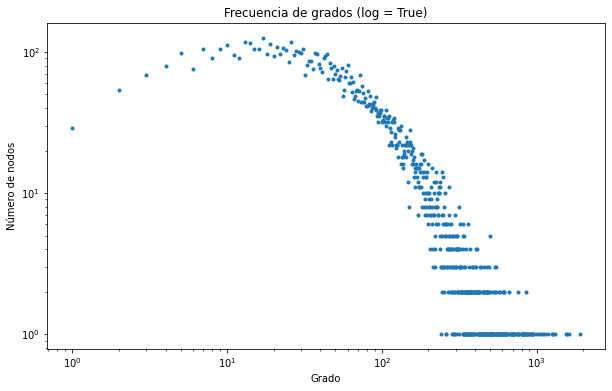

In [21]:
# Pintamos la distribución de la frecuencia de los grados
plot_frecuencia_grados(adjacency_matrix, log=False)
plot_frecuencia_grados(adjacency_matrix, log=True)

En esta red, al observar la frecuencia de los grados, ya vemos que parece que cumple 
una distribución power law, y vemos que la gráfica sin escala logarítmica tiene forma
de long tail, en la que muchos nodos tienen un grado bajo y pocos tienen un grado alto.

Grados ordenados

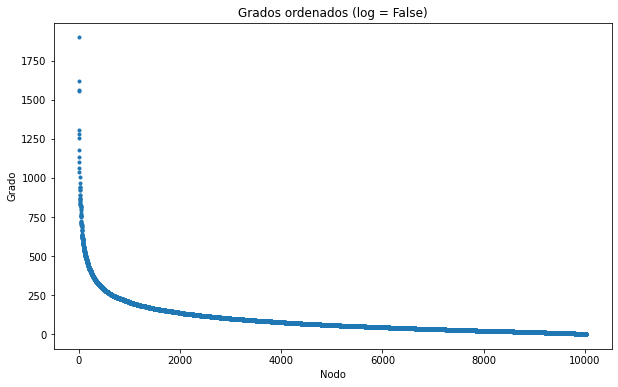

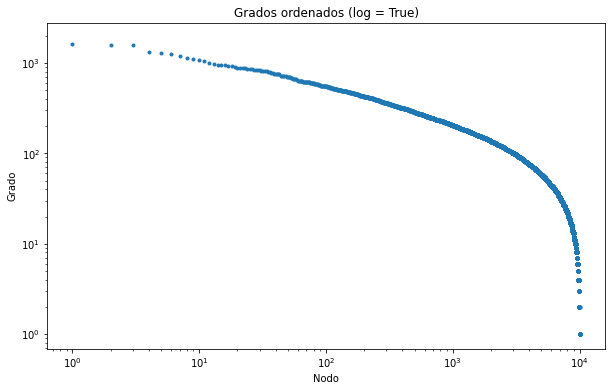

In [22]:
plot_grados_ordenados(adjacency_matrix, log=False)
plot_grados_ordenados(adjacency_matrix, log=True)

Al graficar los grados ordenados, vemos al igual que antes que hay pocos nodos con
un grado alto y vemos que rápidamente el grado de los nodos desciende.

### Análisis red facebook_combined.txt

In [23]:
# Cargamos los datos de las conexiones de la red a un dataframe
red_filename = 'facebook_combined.txt'

file = os.path.join('networks', red_filename)
df = pd.read_csv(file, names=['u', 'v'], delimiter=' ')

# Creamos la matriz de adyacencia a partir de las conexiones
adjacency_matrix = adjacency_matrix_from_df(df)

Distribución de la frecuencia de los grados

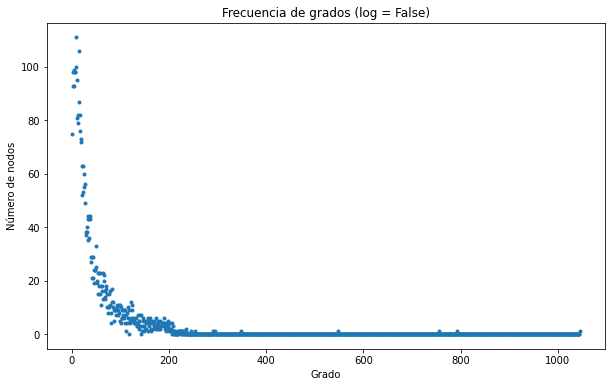

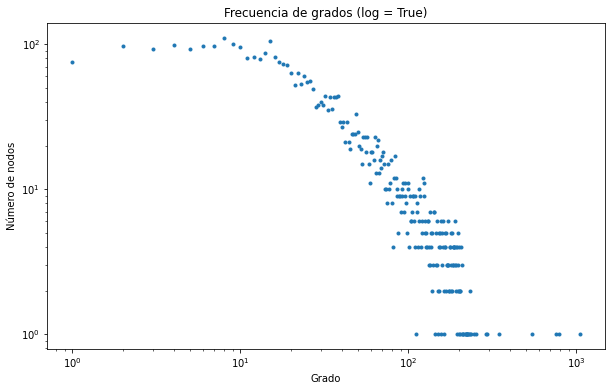

In [24]:
# Pintamos la distribución de la frecuencia de los grados
plot_frecuencia_grados(adjacency_matrix, log=False)
plot_frecuencia_grados(adjacency_matrix, log=True)

En la red de facebook, al igual que en la red de twitter, vemos que la distribución
de los grado parece seguir una ley de potencias y la distribución se parece a una long tail.

Grados ordenados

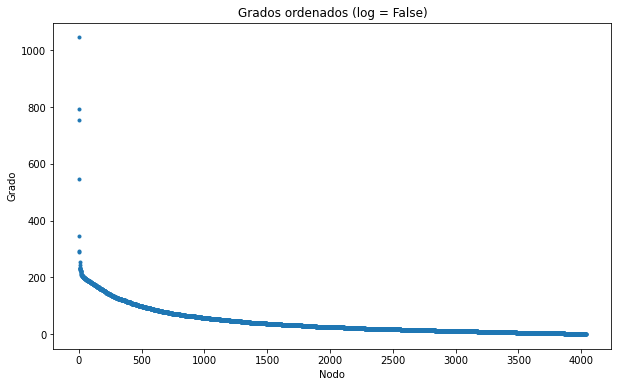

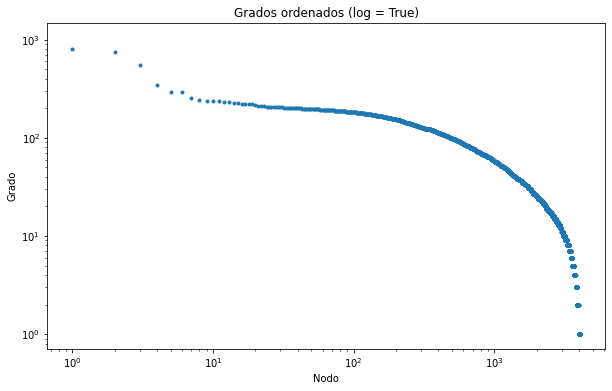

In [25]:
plot_grados_ordenados(adjacency_matrix, log=False)
plot_grados_ordenados(adjacency_matrix, log=True)

Viendo los grados ordenados, se observa lo mismo, al principio hay algunos nodos con muchas
conexiones, y rápidamente el grado de los nodos desciende.

### Análisis red erdos_renyi.csv
Hemos generado una red de Erdös-Rényi con 4000 nodos y una probabilidad de conexión entre
dos nodos de 0.1.

In [26]:
# Cargamos los datos de las conexiones de la red a un dataframe
red_filename = ERDOS_FILENAME

file = os.path.join('networks', red_filename)
df = pd.read_csv(file, names=['u', 'v'], delimiter=',')

# Creamos la matriz de adyacencia a partir de las conexiones
adjacency_matrix = adjacency_matrix_from_df(df)

Distribución de la frecuencia de los grados

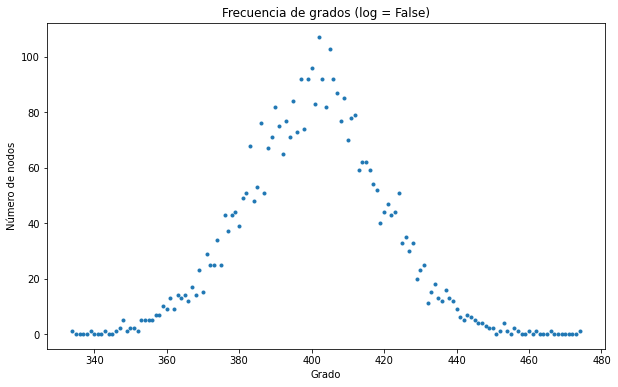

In [27]:
# Pintamos la distribución de la frecuencia de los grados
plot_frecuencia_grados(adjacency_matrix, log=False)

En esta red, como es de esperar por la forma en la que se ha generado, vemos que la
distribución de grados tiene una forma de campana de Gauss, centrada en 400 aproximadamente.
De la teoría, sabemos que la media de los grados es (n-1)*p, y en este caso, n=4000 y p=0.1, 
por lo que gráfica coincide con la teoría.

Grados ordenados

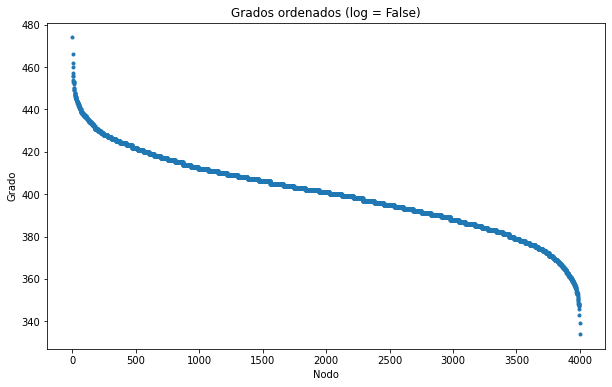

In [28]:
plot_grados_ordenados(adjacency_matrix, log=False)

Al analizar los grados ordenados, vemos que aproximadamente la mitad de los nodos tienen grado mayor que 400, y la otra mitad tienen grado menor que 400, que es lo que se espera que tenga
este tipo de red.

### Análisis red barabasi_albert.csv

Para este red hemos generado 4000 nodos y cada nuevo nodo se conecta con 10 nodos ya existentes.

In [29]:
# Cargamos los datos de las conexiones de la red a un dataframe
red_filename = BARABASI_FILENAME

file = os.path.join('networks', red_filename)
df = pd.read_csv(file, names=['u', 'v'], delimiter=',')

# Creamos la matriz de adyacencia a partir de las conexiones
adjacency_matrix = adjacency_matrix_from_df(df)

Distribución de la frecuencia de los grados

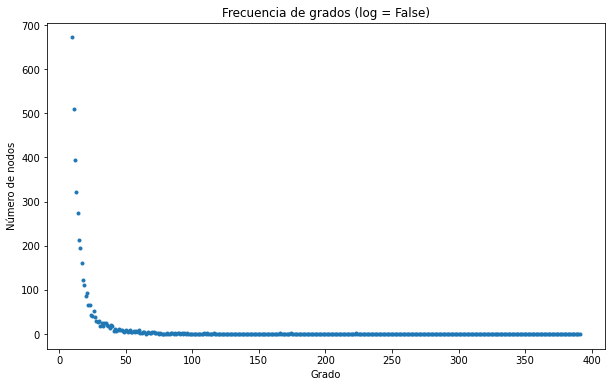

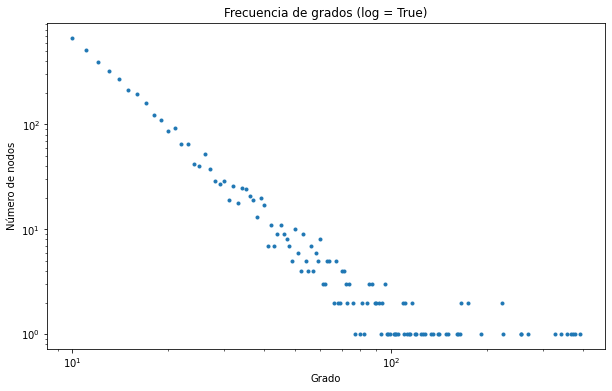

In [30]:
# Pintamos la distribución de la frecuencia de los grados
plot_frecuencia_grados(adjacency_matrix, log=False)
plot_frecuencia_grados(adjacency_matrix, log=True)

En la gráfica sin escala logarítmica vemos que tiene forma de long tail, y al verlo en escala
logarítmica, vemos que se sigue una distribución power law de forma bastante exacta.

Grados ordenados

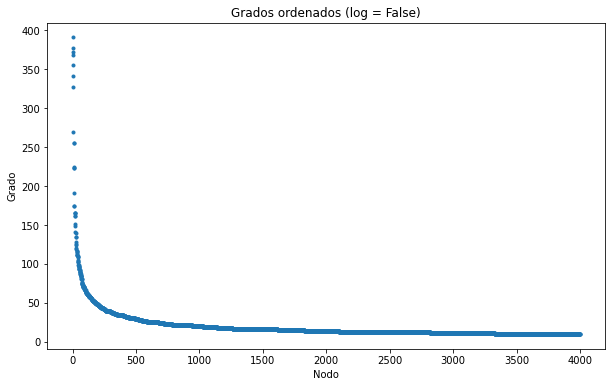

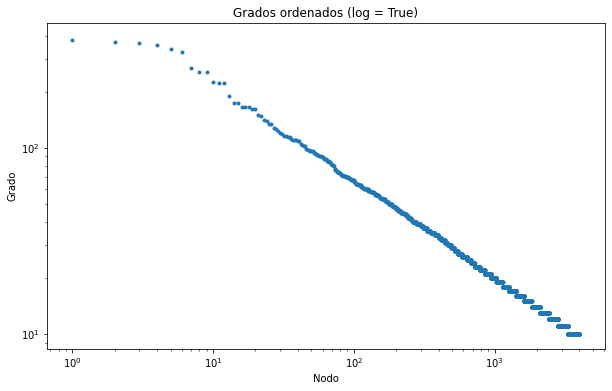

In [31]:
plot_grados_ordenados(adjacency_matrix, log=False)
plot_grados_ordenados(adjacency_matrix, log=True)

Si ordenamos los grados, también se ve que esta red generada sigue una distribución power law.

## Paradoja de la amistad

In [32]:
def friendship_paradox(adjacency_matrix):
    """ Función que devuelve la proporción de nodos que la media de los grados
    de sus amigos es mayor que su grado

    Args:
        adjacency_matrix (numpy array): Matriz de adyacencia de la red

    Returns:
        float: Proporción de nodos que la media de los grados de sus amigos es mayor que su grado
    """
    nodes_degrees = adjacency_matrix.sum(axis=1)

    # Suma de los grados de los amigos de cada nodo
    friends_degrees_sum = adjacency_matrix @ nodes_degrees

    # Media de los grados de los amigos de cada nodo
    friends_degrees_average = friends_degrees_sum / nodes_degrees

    # Proporcion de nodos cuyos amigos tienen un grado mayor que ellos
    proportion = (friends_degrees_average > nodes_degrees).sum() / nodes_degrees.shape[0]

    return proportion

In [33]:
def friends_average(adjacency_matrix):
    """ Función que devuelve el promedio del número de amigos de los amigos. Calcula la suma 
    de los grados de los amigos de cada nodo y lo divide entre el número de conexiones.

    Args:
        adjacency_matrix (numpy array): Matriz de adyacencia de la red

    Returns:
        float: Promedio del número de amigos de los amigos.
    """
    # Grados de los nodos
    nodes_degrees = adjacency_matrix.sum(axis=1)

    # Suma de los grados de los amigos de cada nodo
    friends_degrees_sum = adjacency_matrix @ nodes_degrees

    # Calculamos la suma de todos los grados del número de amigos de los amigos
    friends_degrees_sum = friends_degrees_sum.sum()

    # Calculamos número de conexiones (cada conexión se cuenta dos veces ya que uno es amigo del otro)
    edges = adjacency_matrix.sum()

    # Media de los grados del número de amigos de los amigos
    friends_degrees_average = friends_degrees_sum / edges

    return friends_degrees_average

In [34]:
def friends_average_v2(adjacency_matrix):
    """ Función que devuelve el promedio del número de amigos de los amigos. 
    Lo que hace es primero calcular la media del número de amigos que tienen los amigos de cada nodo,
    y luego hace la media de todos esos valores.

    Args:
        adjacency_matrix (numpy array): Matriz de adyacencia de la red

    Returns:
        float: Promedio del número de amigos de los amigos.
    """
    # Grados de los nodos
    nodes_degrees = adjacency_matrix.sum(axis=1)

    # Suma de los grados de los amigos de cada nodo
    friends_degrees_sum = adjacency_matrix @ nodes_degrees

    # Calculamos la suma de todos los grados del número de amigos de los amigos
    friends_degrees_avg = friends_degrees_sum / nodes_degrees

    # Media de los grados del número de amigos de los amigos
    friends_degrees_average = friends_degrees_avg.mean()

    return friends_degrees_average

In [35]:
files = ['toy1.csv', 'toy2.csv', 'toy3.csv', 'twitter.csv', 'facebook_combined.txt', ERDOS_FILENAME, BARABASI_FILENAME]

separators = [',', ',', ',', ',', ' ', ',', ',']

matrices = []



for file, sep in zip(files, separators):
    file_path = os.path.join('networks', file)
    df = pd.read_csv(file_path, names=['u', 'v'], delimiter=sep)
    matrices.append(adjacency_matrix_from_df(df))

In [36]:
print(f"Proporción de nodos cuyos amigos tienen un grado mayor que ellos:")

for file, adjacency_matrix in zip(files, matrices):
    proportion = friendship_paradox(adjacency_matrix)
    print(f"{file}: {proportion}")

Proporción de nodos cuyos amigos tienen un grado mayor que ellos:
toy1.csv: 0.5
toy2.csv: 0.8888888888888888
toy3.csv: 0.5
twitter.csv: 0.8962010170505534
facebook_combined.txt: 0.874721465709334
erdos.csv: 0.5105
barabasi.csv: 0.9265


Fijándonos en la proporción de nodos cuyos amigos tienen mayor grado que ellos:

En las redes de juguete solo se observa la paradoja de la amistad en toy2, pero estas redes no son de interés.

En las redes reales de Twitter y Facebook, sí vemos que se cumple la paradoja de la amistad, vemos que en la de
Twitter el 89% de los nodos tienen un grado menor que la media de sus amigos, y en la de Facebook el 87%.

En la red de Erdös-Rényi, no se ve la paradoja de la amistad, ya que las conexiones en esta red son totalmente aleatorias.

En cambio, en la red de Barabási-Albert, sí que se ve la paradoja de la amistad, ya que los nodos nuevos se conectan
con los nodos que tienen más conexiones.

In [37]:
print(f"Comparación número de amigos con el promedio del número de amigos de los amigos (Versión 1):")
for file, adjacency_matrix in zip(files, matrices):
    friends_degrees_average = friends_average(adjacency_matrix)
    nodes_degrees_avg = adjacency_matrix.sum(axis=1).mean()
    print(f"{file}:")
    print(f"Media de amigos: {nodes_degrees_avg:0.2f}")
    print(f"Media de amigos de amigos: {friends_degrees_average:0.2f}")

Comparación número de amigos con el promedio del número de amigos de los amigos (Versión 1):
toy1.csv:
Media de amigos: 2.50
Media de amigos de amigos: 2.60
toy2.csv:
Media de amigos: 3.56
Media de amigos de amigos: 4.25
toy3.csv:
Media de amigos: 2.67
Media de amigos de amigos: 2.81
twitter.csv:
Media de amigos: 92.21
Media de amigos de amigos: 230.52
facebook_combined.txt:
Media de amigos: 43.69
Media de amigos de amigos: 106.57
erdos.csv:
Media de amigos: 400.42
Media de amigos de amigos: 401.27
barabasi.csv:
Media de amigos: 19.97
Media de amigos de amigos: 46.92


Mirando el promedio del número de amigos de los amigos de cada nodo, vemos que todas las redes cumplen la paradoja
de la amistad, incluidas las de juguete. Son de especial interés las redes de Twitter y Facebook, ya que son redes
reales. En ellas vemos que la media de los amigos de los amigos de cada nodo es muy superior a la media de los amigos.

En la red de Erdös-Rényi, vemos que la media de los amigos de los amigos de cada nodo es muy similar a la media de los
amigos de cada nodo. Esto se debe a que las conexiones en esta red son totalmente aleatorias.

Y en la red de Barabási-Albert, vemos que se cumple claramente también ya que las conexiones en esta red se hacen en base
a la cantidad de conexiones que tiene cada nodo.

In [38]:
print(f"Comparación número de amigos con el promedio del número de amigos de los amigos (Versión 2):")
for file, adjacency_matrix in zip(files, matrices):
    friends_degrees_average = friends_average_v2(adjacency_matrix)
    nodes_degrees_avg = adjacency_matrix.sum(axis=1).mean()
    print(f"{file}:")
    print(f"Media de amigos: {nodes_degrees_avg:0.2f}")
    print(f"Media de amigos de amigos: {friends_degrees_average:0.2f}")

Comparación número de amigos con el promedio del número de amigos de los amigos (Versión 2):
toy1.csv:
Media de amigos: 2.50
Media de amigos de amigos: 2.67
toy2.csv:
Media de amigos: 3.56
Media de amigos de amigos: 4.48
toy3.csv:
Media de amigos: 2.67
Media de amigos de amigos: 2.85
twitter.csv:
Media de amigos: 92.21
Media de amigos de amigos: 237.11
facebook_combined.txt:
Media de amigos: 43.69
Media de amigos de amigos: 105.55
erdos.csv:
Media de amigos: 400.42
Media de amigos de amigos: 401.28
barabasi.csv:
Media de amigos: 19.97
Media de amigos de amigos: 48.83


En esta segunda versión de la paradoja de la amistad, calculando la media de forma un poco distinta, vemos también que 
se cumple la paradoja de la amistad para todas las redes.

In [39]:
print(f"Comparación mediana con media")
for file, adjacency_matrix in zip(files, matrices):
    nodes_degrees_avg = adjacency_matrix.sum(axis=1).mean()
    nodes_degrees_median = np.median(adjacency_matrix.sum(axis=1))
    print(f"{file}:")
    print(f"Mediana de amigos: {nodes_degrees_median:0.2f}")
    print(f"Media de amigos: {nodes_degrees_avg:0.2f}")

Comparación mediana con media
toy1.csv:
Mediana de amigos: 2.50
Media de amigos: 2.50
toy2.csv:
Mediana de amigos: 3.00
Media de amigos: 3.56
toy3.csv:
Mediana de amigos: 3.00
Media de amigos: 2.67
twitter.csv:
Mediana de amigos: 58.00
Media de amigos: 92.21
facebook_combined.txt:
Mediana de amigos: 25.00
Media de amigos: 43.69
erdos.csv:
Mediana de amigos: 401.00
Media de amigos: 400.42
barabasi.csv:
Mediana de amigos: 14.00
Media de amigos: 19.97


Por último, comparando la mediana de los grados con la media de los grados, vemos que la mediana es menor que la media 
en todas las redes, menos en la toy3, por lo que podemos concluir que también se cumple esta versión de la paradoja
de la amistad.

### Explicación/documentación/imágenes generadas

Todo el código, documentación y gráficas generadas se encuentran en las celdas anteriores.

De este ejercicio podemos destacar que en las redes reales de Twitter y Facebook, la distribución de los grados de los 
nodos parece seguir una ley de potencias, o lo que es lo mismo, tiene una forma de long tail. Esto es algo que se
espera en las redes reales, ya que en ellas hay muchos nodos con un grado bajo y pocos con un grado alto.

También hemos comprobado que la paradoja de la amistad se cumple prácticamente siempre en las redes sociales.

## Ejercicio 6: Métricas (1.5pt)

Se implementarán las siguientes métricas topológicas:

* Coeficiente de **clustering de un usuario**.
* **Arraigo** de un arco (o de un par de usuarios).
* Coeficiente de **clustering de una red social**.
* Coeficiente de **asortatividad** de grado de una red.

Algunas indicaciones en forma de pregunta:

* ¿Cómo obtener la red ego de un usuario en una sóla operación de *slicing* del array 2D de adyacencia?
* ¿Cómo calcular la densidad de una red social en *una* sola operación sobre su matriz de adyacencia? 
* ¿Cómo obtener el solapamiento de los amigos de dos usuarios con una sola operación vectorial?
* ¿Cómo obtener la unión de dos vecindarios de forma eficiente sabiendo su solapamiento?

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import os.path
import networkx as nx
from matplotlib import pyplot as plt

class UndirectedSocialNetwork:
    #
    # In order to spare you some routine coding, we provide this constructor for you, 
    # that builds the basic structures you need to implement your metrics: the network 
    # adjacency matrix, the uid <--> uiidx back and forth mappings, and the number of edges.
    #
    # For your purposes you don't need to go into the implementation details or fully
    # understand every step how they are built -- you just need to use the  provided matrix 
    # and id mapping structure.
    #
    def __init__(self, file, sep=','):
        self.file=file
        edges = pd.read_csv(file, names=['u', 'v'], delimiter=sep)
        edges['r'] = np.ones(len(edges))

        # Take the union of uids, as there may be users who only appear in one data frame column and not the other.
        us = edges.u.unique()
        vs = edges.v.unique()
        self.uids = np.union1d(us, vs)
        self.uidxs = {u:j for j, u in enumerate(self.uids)}
        
        # Add dummy columns (with r=0) so that all userids appear in both data frame columns (otherwise they'd fail
        # to have a row or column in the adjacency matrix). 
        udiff = np.setdiff1d(us, vs)
        vdiff = np.setdiff1d(vs, us)
        edges = pd.concat([edges, pd.DataFrame({'u': vdiff, 'v': np.full(len(vdiff), us[0]), 'r': np.zeros(len(vdiff))})])
        edges = pd.concat([edges, pd.DataFrame({'u': np.full(len(udiff), vs[0]), 'v': udiff, 'r': np.zeros(len(udiff))})])
        
        # Get adjacency matrix.
        edges = edges.pivot(index='u', columns='v', values='r')
        self.m = edges.fillna(0).to_numpy(dtype=np.bool_)
        # Make the adjacency matrix symmetric for an undirected network.
        self.m = np.logical_or(self.m, self.m.T).astype(np.float32)
        # We only count the edges now in case the network file contained reciprocal edges for a directed network,
        # in which case we ignored the edge direction, while the csv file contained more rows than the number of
        # undirected edges.
        self._nedges = self.m.sum()/2

    def matrix(self):
        return self.m

    def nusers(self):
        return len(self.uids)
    
    def nedges(self):
        return self._nedges

    def uid_to_uidx(self, uid):
        return self.uidxs[uid]

    # uidx can be an int of an array of ints.
    def uidx_to_uid(self, uidx):
        return self.uids[uidx]

    def _friends(self, uidx):
        return self.m[uidx].nonzero()[0]
    
    #
    # For debugging purposes.
    #
    
    def degree(self, uid):
        uidx = self.uid_to_uidx(uid)
        return self.m[uidx].sum()

    def friends(self, uid):
        return [self.uidx_to_uid(uidx) for uidx in self._friends(self.uid_to_uidx(uid))]

    #
    # Network metrics.
    #

    # Global computation of the clustering coefficient (micro-average).
    def clustering(self):
        m = self.matrix()

        # Matriz de adyacencia al cuadrado nos da el numero de caminos de longitud 2 entre los
        # nodos i y j en la posicion (i,j) de la matriz.
        m2 = m @ m

        # Matriz de adyacencia al cubo nos da el numero de caminos de longitud 3 entre los
        # nodos i y j en la posicion (i,j) de la matriz.
        m3 = m2 @ m

        # Los caminos de longitud 3 que empiezan en nodo i y acaban en i son los triangulos.
        # Por tanto, la diagonal de la matriz m3 nos da el numero de triangulos que pasan por
        # cada nodo. Como cada triangulo tiene 3 nodos, dividimos por 3, ya que estamos contando
        # los caminos cerrados de longitud 3 para cada uno de los nodos del triangulo. Y como cada
        # nodo del triangulo puede ir en 2 direcciones, dividimos por 2.
        num_triangles = m3.diagonal().sum()/6

        # Una tripleta es un camino de longitud 2 que empieza en i y acaba en j, i != j.
        # Por eso, ponemos la diagonal a 0, porque no queremos contar los caminos que son
        # ir de un nodo a otro, y volver al mismo nodo. Al final dividimos por 2 para no 
        # contar dos veces cada camino.
        np.fill_diagonal(m2, 0)
        num_triplets = m2.sum()
        num_triplets = (num_triplets) / 2

        return 3*num_triangles / num_triplets

    def assortativity(self):
        # Código aquí...
        pass

    #
    # User metrics.
    #
    
    # Network clustering coefficient as the average clustering coefficient of users.
    def avg_clustering(self):
        return UserMetric(self, np.array([self.user_clustering(uidx) for uidx in range(self.nusers())]))

    # Clustering coefficient of individual user - just needed for the average CC.
    def user_clustering(self, uidx):
        # Obtenemos los índices de los amigos de uidx
        friends = self._friends(uidx)
        if len(friends) < 2:
            return 0
        else:
            # Obtenemos la submatriz con la red ego
            ego = self.matrix()[friends][:, friends]

            # Número de conexiones en la red ego. Dividimos entre dos para no contar dos veces cada conexión.
            num_connections_in_ego = ego.sum() / 2

            num_possible_connections = len(friends) * (len(friends) - 1) / 2

            return num_connections_in_ego / num_possible_connections
    #
    # Edge metrics.
    #

    def embeddedness(self):
        m = self.matrix()

        # Matriz con el número de elementos en la interseccion
        intersections = m @ m.T

        # Unions es una matriz con el número de elementos en la unión
        degrees = m.sum(axis=1)

        # El número de elementos en la unión es la suma de los grados de los nodos i y j,
        # menos el número de elementos en la intersección.
        unions = np.add.outer(degrees, degrees) - intersections

        # Restamos 2*m para no tener en cuenta al elemento i y al elemento j, en el calculo de Jaccard.
        unions = unions - 2 * m

        # Matriz con 1 en las posiciones donde los elementos i y j tienen ambos grado 1.
        aux = np.logical_and(degrees == 1, degrees[:, np.newaxis] == 1)

        # En los elementos ij donde ambos tienen grado 1, la intersección es 0 y la unión es 2,
        # y al haber restado 2*m, nos queda un 0, por eso sumamos 1.
        # No importa que sumemos un 1 de más en los elementos donde ambos tienen grado 1 pero no están conectados,
        # porque en la matriz de intersecciones, en esos elementos ya tenemos un 0, lo cual no afectará al resultado
        # final del arraigo.
        unions = unions + aux

        # El arraigo de un elemento consigo mismo es 1
        np.fill_diagonal(intersections, 1)
        np.fill_diagonal(unions, 1)

        return EdgeMetric(self, intersections / unions)

#
# Auxiliary classes to hold and return values of user metrics and edge metrics.
#
    
# Aiming to spare you some routine coding, the purpose of these two classes is 
# to hold the metric values through their constructur, and return the mean and 
# ranked values of user and edge metrics when requested. 
#
# For your purposes you don't need to go into the implementation details, or
# understand every step of these functions -- you just need to use the simple
# API they provide.
    
class UserMetric:
    def __init__(self, network, values):
        self.network = network
        self._values = values
        self.sorted_uidx = (rankdata(-values, method='ordinal')).argsort()

    # Return the mean value across all users in the network.
    def mean(self):
        return self._values.mean()

    # Return the metric value for one user.
    def value(self, uid):
        return self._values[self.network.uid_to_uidx(uid)]

    # Return a dictionary with the top n users in the metric.
    def values(self, n):
        return {l:fround(v, 4) for l, v in zip(self.network.uids[self.sorted_uidx[:n]],
                                                   self._values[self.sorted_uidx[:n]])}

class EdgeMetric:
    def __init__(self, network, values):
        self.network = network
        values[np.tril_indices(values.shape[0])] = np.iinfo(int).min
        self._values = values
        tri = int(network.nusers() * (network.nusers() - 1) / 2)
        self.order = np.dstack(np.unravel_index(np.argsort(rankdata(-values.ravel(), method='ordinal')), values.shape))[0][:tri]
        self.ordered_values = np.array([self._values[e[0],e[1]] for e in self.order])

    # Return the mean value across all edges in the network.
    def mean(self):
        return self.ordered_values.mean()

    # Return the metric value for one edge (the edge may or may not exist).
    def value(self, uid, vid):
        uidx, vidx = self.network.uid_to_uidx(uid), self.network.uid_to_uidx(vid)
        return self._values[min(uidx, vidx), max(uidx, vidx)]

    # Return a dictionary with the top n edges in the metric.
    def values(self, n):
        n = min(n, len(self.order))
        return {tuple(self.network.uidx_to_uid(e)):fround(self._values[e[0],e[1]], 4) for e in self.order[:n]}
    
# Just for pretty-printing numbers.
def fround(x, n=20):
    r = round(x)
    rn = round(x, n)
    return r if rn == r else rn

### Explicación/documentación

A continuación comentamos las implementaciones de el coeficiente de clustering de un usuario, coeficiente de clustering
global de una red social y el embeddedness:

- **Coeficiente de clustering de un usuario** <br>
Para calcular el coeficiente de clustering de un usuario, lo que se hace es obtener la red ego de un usuario. Para ello,
obtenemos los índices de los amigos de ese usuario, y con esos índices seleccionamos esas filas de la matriz de
adyacencia y después seleccionamos las columnas de los amigos de ese usuario. De esta forma, obtenemos una submatriz
con la red ego del usuario. Después calculamos el número de conexiones entre vecinos del usuario, que es la suma
de los elementos de la submatriz, y dividimos entre dos para no contar la misma conexión dos veces. Y por último,
el número de conexiones posibles entre vecinos de un usuario u es simplemente es: (grado(u)*(grado(u)-1))/2. Y el 
coeficiente de clustering es el número de conexiones entre vecinos / número de conexiones posibles entre vecinos.

- **Coeficiente de clustering global** <br>
Para calcular esto, necesitamos el número de triángulo en la red y el número de tripletas conectadas.

Si A es la matriz de adyacencia de una red, el elemento (i,j) de A^2 es el número de caminos de longitud 2 entre los
nodos i y j. Con A^3 es lo mismo, con caminos de longitud 3. Por lo tanto, para el número de triángulos en la red,
lo que hacemos es calcular la suma de los elementos de la diagonal de A^3, que nos da los caminos cerrados de
longitud 3, es decir, los triángulos; y dividir entre 6, ya que cada triángulo se cuenta 6 veces 
(3 por cada nodo del triángulo, y 2 por cada uno de los sentidos en cada nodo).

Una tripleta conectada es un camino de longitud 2, donde el nodo de origen y destino del camino no son el mismo nodo.
Por eso, utilizamos A^2 poniendo la diagonal a 0, y sumamos todos los elementos de la matriz, y dividimos entre 2, para
no contar dos veces cada camino.

Por último, el coeficiente de clustering global es el 3 * número de triángulos en la red / número de tripletas conectadas.

- **Embeddedness** <br>
Para calcular el embeddedness, necesitamos para cada par de usuarios (u,v), el Jaccard entre vecinos de u \ {v} y 
vecinos de v \ {u}. Para ello necesitamos calcular el módulo de la intersección de los vecinos de u y v, y el módulo
de la unión de los vecinos de u y v.

Para calcular la intersección, hacemos simplemente la multiplicación de la matriz de adyacencia por su transpuesta,
lo que nos da en cada elemento (i,j) el número de vecinos en común entre los nodos i y j.

Para calcular la unión, primero calculamos el grado de cada nodo, y después, el elemento (i,j) de la matriz 
con el número de elementos en la unión es la suma de los grados de los nodos i y j, menos el número de elementos en
la intersección, que ya lo hemos calculado antes. Para ello, hacemos la "suma outer" entre los grados de los nodos,
y restamos la matriz de intersecciones calculada anteriormente. Después, restamos 2 * matriz de adyacencia, ya que
no queremos tener en cuenta a los propios elementos u,v en el cálcula de Jaccard. Y finalmente sumamos 1 a los 
elementos en los que el grado de u y v es 1, por la definición de arraigo. No importa que sumemos un 1 de más en los
elementos donde ambos tienen grado 1 pero no están conectados, porque en la matriz de intersecciones, en esos elementos
ya tenemos un 0, lo cual no afectará al resultado final del arraigo.

Y por último, para calcular Jaccard, dividimos la matriz de intersecciones entre la matriz de uniones.

Además, se documentarán en la memoria los tiempos de ejecución de las métricas en las redes de Facebook y Twitter, en una tabla con la siguiente estructura:

Nota: El tiempo de ejecución del coeficiente de clustering de un usuario se corresponde con el cálculo del macro average.

||Facebook|Twitter
|-|:-:|:-:
|Coef. clustering usuario|0:00:01|0:00:16
|Embededness|0:00:11|0:00:59
|Coef. clustering global|0:00:05|0:01:50
|Asortatividad|...|...

## Ejercicio 7: Ejercicio libre (fuera de puntuación)

El estudiante desarrollará uno o varios métodos de análisis de redes a su propia elección. Se sugiere por ejemplo: 

* Implementación de métricas adicionales, tales como betweenness, closeness, distancia promedio, diámetro, modularidad, etc. (Para la modularidad, se necesitará definir una partición de los nodos &ndash; consultar con el profesor.)
* Detección de comunidades y enlaces débiles.
* Creación de modelos para la generación aleatoria de redes sociales (p.e. amigos de amigos, etc.).
* Recomendación de contactos.

Para este ejercicio deberá completarse la implementación de una función adicional `student_test()` ilustrando la ejecución de las métricas y algoritmos implementados. 

El software que se desarrolle se incluirá en la celda que sigue, y se documentarán en la memoria las pruebas realizadas y los resultados obtenidos. 

Este ejercicio se evaluará en base a la cantidad, calidad e interés del trabajo realizado.

In [42]:
# Implementación o implementaciones elegidas

In [43]:
def student_test(data):
    pass
    # Código aquí...

### Explicación/documentación

(por hacer)

## Visualización de las redes pequeñas de prueba

Descarga los ficheros del curso de Moodle y coloca sus contenidos en una carpeta **networks** en el mismo directorio que este *notebook*. Visualizar las redes de prueba facilita las comprobaciones que puedan ser necesarias durante la depuración del código.

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import os.path
import networkx as nx
from matplotlib import pyplot as plt

networks/toy1.html
networks/toy2.html
networks/toy3.html


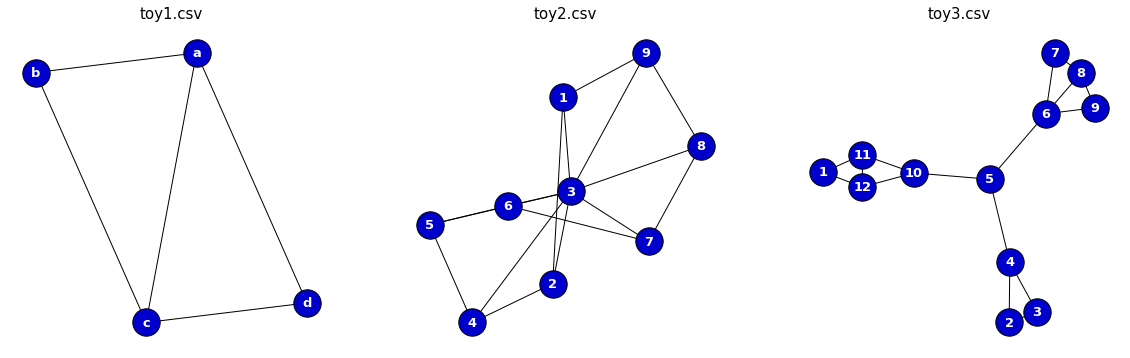

In [45]:
from pyvis.network import Network

def plot(file, ax=None, sep=','):
    g = nx.from_pandas_edgelist(pd.read_csv(file, names=['u', 'v'], delimiter=sep), 
                                source='u', target='v')
    options = {
        'node_size': 750, 'node_color': 'mediumblue', 'edgecolors': "black",
        'font_color': 'white', 'font_weight': 'bold', 'font_size': 13
    }
    if not ax: 
        f = plt.figure()
        f.set_size_inches(3, 3)
        
    # Plot the graphs in the output cell.
    nx.draw(g, ax=ax, with_labels=True, **options)
    filename = os.path.split(file)[1]
    (ax if ax else plt.gca()).set_title(filename, fontsize=15)
    
    # Plot the graphs into interactive HTML files.
    net = Network(notebook=True, cdn_resources='remote')
    net.from_nx(g)
    net.show(file.split('.')[0] + '.html')
    

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(20, 6)
plot('networks/toy1.csv', ax1)
plot('networks/toy2.csv', ax2)
plot('networks/toy3.csv', ax3)

## Celda de prueba

In [46]:
import datetime, time

def test_network(file, topn, example_u, example_v, sep=','):
    print(f'==================================================\nTesting {file} network')
    network = UndirectedSocialNetwork(file, sep=sep)
    print(f'Network matrix takes {round(10 * network.matrix().nbytes / 1024 / 1024) / 10:,} MB in RAM')
    print(f'{network.nusers():,} users and {network.nedges():,} contact relationships')
    print(f'User {example_u} has {network.degree(example_u):,} contacts: ', network.friends(example_u))
    print('-------------------------')
    start = time.time()
    c = network.avg_clustering()
    print(f'User clustering coefficient (top {topn}): {c.values(5)}')
    print(f'  CC({example_u}) =              {c.value(example_u)}')
    print('Network clustering coefficient:')
    print(f'  Macro-average =      {c.mean()}')  
    start = timer(start)
    print(f'  Micro-average =      {network.clustering()}')
    #start = timer(start)
    # print(f'Assortativity =        {network.assortativity()}')
    start = timer(start)
    e = network.embeddedness()
    print(f'Edge embeddedness (top {topn}): {e.values(5)}')
    print(f'  Embeddedness({example_u}, {example_v}) = {e.value(example_u, example_v)}')
    print(f'  Average =            {e.mean()}')
    timer(start)

    # Otros tests?
    student_test(network)

from termcolor import colored
def timer(start):
    print(colored(f'  --> elapsed time: {datetime.timedelta(seconds=round(time.time() - start))} <--', 'blue'))
    return time.time()
    
test_network('networks/toy1.csv',              topn=5, example_u='a',       example_v='b')
test_network('networks/toy2.csv',              topn=5, example_u=5,         example_v=6)
test_network('networks/toy3.csv',              topn=5, example_u=6,         example_v=4)
test_network('networks/facebook_combined.txt', topn=5, example_u=9,         example_v=3, sep=' ')
test_network('networks/twitter.csv',           topn=5, example_u='el_pais', example_v='ElviraLindo') # Contains a number of reciprocal edges but we ignore direction.
test_network('networks/barabasi.csv',          topn=5, example_u=2000,         example_v=3000)
test_network('networks/erdos.csv',             topn=5, example_u=2000,         example_v=3000)
print('==================================================\nDone.')

Testing networks/toy1.csv network
Network matrix takes 0.0 MB in RAM
4 users and 5.0 contact relationships
User a has 3.0 contacts:  ['b', 'c', 'd']
-------------------------
User clustering coefficient (top 5): {'b': 1, 'd': 1, 'a': 0.6667, 'c': 0.6667}
  CC(a) =              0.6666666666666666
Network clustering coefficient:
  Macro-average =      0.8333333333333333
  --> elapsed time: 0:00:00 <--
  Micro-average =      0.75
  --> elapsed time: 0:00:00 <--
Edge embeddedness (top 5): {('a', 'c'): 1, ('b', 'd'): 1, ('a', 'b'): 0.5, ('a', 'd'): 0.5, ('b', 'c'): 0.5}
  Embeddedness(a, b) = 0.5
  Average =            0.6666666865348816
  --> elapsed time: 0:00:00 <--
Testing networks/toy2.csv network
Network matrix takes 0.0 MB in RAM
9 users and 16.0 contact relationships
User 5 has 3.0 contacts:  [3, 4, 6]
-------------------------
User clustering coefficient (top 5): {1: 0.6667, 2: 0.6667, 4: 0.6667, 5: 0.6667, 6: 0.6667}
  CC(5) =              0.6666666666666666
Network clustering coe

### Salida obtenida por el estudiante
```
==================================================
Testing networks/toy1.csv network
Network matrix takes 0.0 MB in RAM
4 users and 5.0 contact relationships
User a has 3.0 contacts:  ['b', 'c', 'd']
-------------------------
User clustering coefficient (top 5): {'b': 1, 'd': 1, 'a': 0.6667, 'c': 0.6667}
  CC(a) =              0.6666666666666666
Network clustering coefficient:
  Macro-average =      0.8333333333333333
[34m  --> elapsed time: 0:00:00 <--[0m
  Micro-average =      0.75
[34m  --> elapsed time: 0:00:00 <--[0m
Edge embeddedness (top 5): {('a', 'c'): 1, ('b', 'd'): 1, ('a', 'b'): 0.5, ('a', 'd'): 0.5, ('b', 'c'): 0.5}
  Embeddedness(a, b) = 0.5
  Average =            0.6666666865348816
[34m  --> elapsed time: 0:00:00 <--[0m
==================================================
Testing networks/toy2.csv network
Network matrix takes 0.0 MB in RAM
9 users and 16.0 contact relationships
User 5 has 3.0 contacts:  [3, 4, 6]
-------------------------
User clustering coefficient (top 5): {1: 0.6667, 2: 0.6667, 4: 0.6667, 5: 0.6667, 6: 0.6667}
  CC(5) =              0.6666666666666666
Network clustering coefficient:
  Macro-average =      0.6243386243386244
[34m  --> elapsed time: 0:00:00 <--[0m
  Micro-average =      0.46153846153846156
[34m  --> elapsed time: 0:00:00 <--[0m
Edge embeddedness (top 5): {(1, 4): 0.5, (1, 8): 0.5, (2, 5): 0.5, (2, 9): 0.5, (4, 6): 0.5}
  Embeddedness(5, 6) = 0.3333333432674408
  Average =            0.3153439164161682
[34m  --> elapsed time: 0:00:00 <--[0m
==================================================
Testing networks/toy3.csv network
Network matrix takes 0.0 MB in RAM
12 users and 16.0 contact relationships
User 6 has 4.0 contacts:  [5, 7, 8, 9]
-------------------------
User clustering coefficient (top 5): {1: 1, 2: 1, 3: 1, 7: 1, 9: 1}
  CC(6) =              0.3333333333333333
Network clustering coefficient:
  Macro-average =      0.6666666666666666
[34m  --> elapsed time: 0:00:00 <--[0m
  Micro-average =      0.5172413793103449
[34m  --> elapsed time: 0:00:00 <--[0m
Edge embeddedness (top 5): {(2, 3): 1, (7, 9): 1, (11, 12): 1, (1, 10): 0.6667, (6, 8): 0.6667}
  Embeddedness(6, 4) = 0.1666666716337204
  Average =            0.16363637149333954
[34m  --> elapsed time: 0:00:00 <--[0m
==================================================
Testing networks/facebook_combined.txt network
Network matrix takes 62.2 MB in RAM
4,039 users and 88,234.0 contact relationships
User 9 has 57.0 contacts:  [0, 3, 21, 25, 26, 30, 56, 66, 67, 69, 72, 75, 79, 85, 105, 113, 119, 122, 128, 133, 134, 141, 142, 148, 156, 161, 169, 170, 176, 185, 186, 188, 199, 200, 203, 224, 231, 232, 252, 258, 271, 272, 276, 277, 280, 285, 291, 295, 297, 304, 315, 322, 323, 329, 334, 341, 342]
-------------------------
User clustering coefficient (top 5): {32: 1, 33: 1, 35: 1, 42: 1, 44: 1}
  CC(9) =              0.39724310776942356
Network clustering coefficient:
  Macro-average =      0.6055467186200862
[34m  --> elapsed time: 0:00:01 <--[0m
  Micro-average =      0.5191743332795125
[34m  --> elapsed time: 0:00:05 <--[0m
Edge embeddedness (top 5): {(4, 181): 1, (4, 275): 1, (6, 147): 1, (8, 91): 1, (8, 259): 1}
  Embeddedness(9, 3) = 0.22033898532390594
  Average =            0.011249924078583717
[34m  --> elapsed time: 0:00:11 <--[0m
==================================================
Testing networks/twitter.csv network
Network matrix takes 383.7 MB in RAM
10,029 users and 462,399.0 contact relationships
User el_pais has 1,899.0 contacts:  ['1001Medios', '101kmsolidarios', '112Asturias', '112PcivilMieres', '112cmadrid', '90mn90d', 'A3Noticias', 'ABBIOTICS', 'ACCC_', 'ADD_UC3M', 'ADPrietoPYC', 'AEM_112', 'AGalan7', 'AJEValencia', 'AJEnglish', 'AMPAPrincipeAst', 'AMPA_Verbena', 'APDasociacion', 'APNABI', 'ARCECAC', 'ARREBOLARP', 'ASACAMV', 'ASSIRIANE', 'AS_CarmenColino', 'AS_Relano', 'ATrullols', 'AUTISMO_ESPANA', 'A_Valenzuela', 'A__Velazquez', 'Abernardo', 'AberronchoTV', 'Acfernandez_es', 'ActualidadU', 'AdaColau', 'Adif_es', 'AdorianZ', 'AdriaPunti', 'AdrianaRey83', 'Aemet_Esp', 'AfectadoBSCH012', 'AgCastellote', 'AgenciaAtlas', 'AgendadeEmpresa', 'Aicespain', 'Aidamendez3', 'AjebaskAlava', 'AjoMicropoetisa', 'AlSisam', 'AlbaCP26', 'AlbaHerranzdln', 'AlbertMonteys', 'Albert_Rivera', 'AlbertoGomezB', 'AlbertoNeff', 'Alberto_pg13', 'AlecEvan', 'AleixEspargaro', 'AleixSalo', 'AlertaMeteo', 'AlexODogherty', 'Alex_candal', 'AlexdelaMora', 'Alexrs95', 'Alexserramar', 'Alfonso_Egea', 'AlgeMarroncelli', 'Alibaimor', 'Alibcia', 'AlicRuiz', 'Aliciaesm', 'AllBranKellogs', 'AlmuConil', 'AlodiaBlanco', 'AlvaroUribeVel', 'Alvaro_DMC', 'Alvaro_Zancajo', 'Alvy_Singer', 'AmayaConde', 'AmayaSanfabio', 'Ambulante', 'AmericaGovEsp', 'AnaUsle', 'Ana_CaGi', 'AndresG_Dorado', 'AndresPerezGil', 'AngelMSastre', 'AngelMoyatv', 'AngelaAlcover', 'AngelesBlancoTV', 'AnitaAyanz', 'AntonioCamunas', 'AntonioJplinan', 'AntonioMiguelC', 'AraReina', 'Aran76', 'ArandaElviro', 'Arantza_Lopez', 'ArbezRM', 'ArgeliaQueralt', 'Ariadnasue', 'ArodSpainMedia', 'Arqtecturizada', 'ArtaMallorca', 'ArteMexico', 'AsernaS', 'Azahara_CB', 'BANASTERO', 'BBCBreaking', 'BCastrillo', 'BIOVAL_es', 'BNE_directora', 'BVP990', 'B_cuevas', 'Barajas_el', 'BarbaraOteiza', 'Barbara_RuizP', 'Barbaraalpuente', 'Barbijaputa', 'Barksdale666', 'Batmanchuca', 'Bealonso', 'Beatriz_gc', 'BeitaArma', 'BelFebrer', 'BelenHerreros', 'BelenXestal', 'Berasategui', 'Berlustinho', 'Betinaserrano', 'BiblioItesmAGS', 'BiblioUBA', 'BibliotecaDRH', 'BibliotecaEEA', 'Biblioteca_UNED', 'BibliotecadStgo', 'BigBangCiencia', 'Biqfr_CSIC', 'BitDefenderES', 'Blan_10', 'BlancaPombo', 'BobPopVeTV', 'BolsacomTrading', 'BomberosAstur', 'Borja_Pardo', 'Bortibort', 'BrandsofSpain', 'BreakingNews', 'BrujulaOndaCero', 'BrunaHusky', 'BrunoCendon', 'BuenasNochesBFN', 'CCorcho', 'CEIPausias', 'CENIEH', 'CERSIAEmpresa', 'CHAROESG', 'CMU_Isabel', 'CNNEE', 'COEPAlicante', 'CONGREGA_BB', 'CPSantiso', 'Cabanillas1165', 'Cabeza_Viviente', 'Cajonenfermeria', 'Caleonvi', 'Calvoroy', 'Caminanteloc', 'Cansaliebres_', 'Carbonellsg', 'Carlapvera', 'Carles5puyol', 'Carliss96', 'CarlosChapinal', 'CarlosDiezSan', 'Carlos_Latre', 'CarlottaBosch', 'CarmeChaparro', 'CarmelaRios', 'CarmenAngos', 'CarmenSerrana', 'CarmendelRiego', 'CarodRoviraJLl', 'CarvinKlein', 'CasaCiencia_Sev', 'Casal', 'Catatonic_Toy', 'CepymeAlicante', 'Charlymoya', 'ChefCharlyCook', 'ChusHeredia', 'Cincodiascom', 'CinesRenoir', 'CinetecaMadrid', 'CiudadanoPerro', 'Clar_Loves', 'Clara19917', 'ClaraMattaldi', 'ClaudFrau', 'ClaudiaFernn', 'ColegioEmeritos', 'ComunicatingGG', 'ComunidadMadrid', 'ConCienciaUC3M', 'ConchaGuerra', 'CondeDeLaFere', 'Copedelasierra', 'Coque_Malla', 'Cottes_Group', 'CrespoAranda', 'CrisBeltran', 'Cris_Puig', 'CristinaGlez_tv', 'CristinaOnega', 'Cristinahermo', 'CronicaNorte', 'CruzRojaMadrid', 'Cuellar24', 'CuleDeshauciado', 'CulturaBiotec', 'CulturaUNAM', 'Cupset', 'DBrownier', 'DChicharro', 'DJM_9', 'DSantosMunoz', 'DYAnoticias', 'Damianmolla', 'DaniCasGut', 'DaniPedrosa', 'DaniSordo', 'Dani_sexposito', 'DanielaFeblesM', 'DavidCardona1', 'DavidTaguas', 'David_Noriega', 'DazHerrero', 'DdeDuro', 'DebatAlRojoVivo', 'DeborahFdezTv', 'Declaracion', 'Defensagob', 'Deloitte_Spain', 'DemosUC3M', 'Des_bordes', 'DesayunoDudas', 'DianaRPretel', 'DianaSanBenito', 'DiegOstiaputa', 'Diegohv101', 'DigiLivingUC3M', 'DircomNews', 'DiscosdeKirlian', 'Divulgameteo', 'DoriToribio_Rne', 'EMenlluita', 'ENAEbusiness', 'ENEmuseo', 'EOILorca', 'EOR4444', 'EPEconomia', 'EPMadrid', 'ERodrigalvarez', 'ESNI_Cursos', 'ETSIMINAS_UPM', 'Earmenteros', 'EcoCote', 'EcoEFC', 'EdicionesPaidos', 'EditoresDTebeos', 'EditorialLALEY', 'EduMadina', 'EduPolo', 'EduardOrtegaNO', 'EduardoNavarro9', 'EdufeBlanco', 'Efgtotal', 'Egrett', 'ElHuffPost', 'ElToubabMusic', 'El_Hormiguero', 'ElenaHeBe', 'ElenaTdebon', 'Elena_NE', 'Elena__Perez', 'Eliana_Fuentes', 'Elillopez', 'ElogioLocura', 'ElviraLindo', 'Emergencias112', 'Enawebseriada', 'Enplanas', 'EnriMR', 'Enric_Hernandez', 'Equo', 'Erratanaturae', 'EspejoPublico', 'EspeonzaAguirre', 'EsppeonzAguirre', 'Esri_Spain', 'EsteffiE_tv', 'EstelaCiria', 'Esterresani1', 'EstherVaqueroH', 'EstrellaDammCat', 'EugeniaToledo', 'Eva_SuarezM', 'EvieMmm', 'FJBARROSO1973', 'FJavierAyuso', 'FT', 'FVallespin', 'Farodevigo', 'FeFe_PRC', 'FedMadMontana', 'Felisuco_', 'Felixzizou', 'FerGarats', 'FerUve', 'FerValmaseda', 'Ferdy89', 'FernanLopezMesa', 'FernanSQL', 'Fernando_Llano_', 'Ferrero_trp', 'Fgarea', 'Flofdez', 'FonsecaFj', 'Forestalx', 'ForoNuclear', 'Fotlipou', 'FranPatino', 'Fran_Sarrio', 'Franelarquero', 'Frank_Blanco', 'Fund451', 'FundacionLeer', 'GVazquezNatalia', 'Gabri_Allin', 'Gabrielhdez_', 'Gafasaos', 'GalderReguera', 'GalianaLM', 'GaliciaCowork', 'GallizoMercedes', 'GamaVilallonga', 'GarciaAller', 'GarrinchaCF', 'GemaMorcillo', 'GemaNievesR', 'Gemmanf', 'Georgiana_30', 'GerryDawes', 'Gessamina', 'Gfouce', 'GiampaManfreda', 'GibsonSpain', 'Gloria_Lozano', 'Gnescudero', 'GonzaloFanjul', 'Gonzalozt', 'GoodwillComunic', 'Gorka_Maneiro', 'Goyojimenez', 'GuCampus', 'Guardiacivil062', 'Guardiolato', 'Guerreando', 'GuilleMarley', 'Guille_Piquero', 'GuillemBalague', 'Guillemmartnez', 'GuillermOngayo', 'Gurusblog', 'HPEspana', 'HaidoRoLa', 'Harley66', 'Herzogoff', 'HoyporHoySER', 'Hyperher', 'IAB_Spain', 'IB_Franklin', 'ICYT_UC3M', 'IEbusiness', 'INGeBOOK', 'IPJLuc3m', 'IP_Palacios', 'ITechPreneur', 'IbercampusES', 'IgNacto87', 'IgnacioCampoy1', 'InakiUrrutia', 'IndraCompany', 'Ingenieria_Esp', 'InigoNavarro', 'InmaNiebla', 'Innobasque', 'InstCervantes', 'Instint_tv', 'InterAravaca', 'Interviu_', 'IosudelaTorre', 'Iplari', 'Ireee_DDiego', 'Irene_montala_', 'IrnMM', 'IroniaMan', 'IsaGalvache', 'IsabelUrkijo', 'IsaboIsica', 'IsaiasLafuente', 'Itxaso_TVAE', 'IvanMR10', 'IzaskunUB', 'JALGUERRERO', 'JCNyst', 'JCarbs_', 'JCarlosCrespo', 'JGALLEGOonfire', 'JJ_Agredano', 'JLSaezR', 'JMMartin37', 'JOAQUINMI101', 'JRIturriaga', 'JTorres_86', 'Jack_skr', 'JaimeAnguloIbar', 'JaimerlG', 'JamalDols', 'JandroTIC', 'Januky1', 'Jason_Voorhess', 'JaumeBarbera', 'Jav_Savio', 'JaviBanuelos', 'JaviGundin', 'Javi_Martz', 'JavierBlancoH', 'JavierDoradoP', 'JavierGarcia1', 'JavierJaenB', 'JavierLoMe', 'JavierMorenoIA', 'Javimartin1411', 'JavoCaste', 'JavyRock69', 'JbyChepa', 'JennySantos1985', 'JesusCalleja', 'JesusCintora', 'JesusEncinar', 'JesusGoni', 'Jesus_Servulo', 'Jiwert', 'JordiCervera', 'Jordisk', 'JorgeAlacid1', 'JorgeFabraU', 'JoseMendoza24', 'JoseOrlando_Mx', 'Josemi_Carmona', 'JotaAbril', 'JpDemocracia', 'Jqronsmans', 'Jr_Frankenstein', 'JuanCruzTuiter', 'JuanGomezJurado', 'JuanJoseMateo', 'JuanJoseMillas', 'JuanMariBeltran', 'Juanita8ac', 'JuanmaLemkus', 'Juanmafilms', 'JuanvilHerrera', 'JulianAvila1', 'JulianSiniestro', 'JulioSomoano', 'JulioTejedorB', 'Jurismario', 'Kalstodon', 'Karmentxumarin', 'Kikekuc', 'KiraMiro', 'Klarilis', 'KnowMediaLab', 'KooKooee', 'Korrecamino', 'LA_PAH', 'LQDVI', 'LaCostaComunica', 'LaEtxebarria', 'LaIguanaClub', 'LaRedInnova', 'LaVanguardia', 'La_Coronel', 'La_SER', 'LahuSimon', 'Lara_TVAE', 'Largocreatura', 'LarrySion', 'Lau3L', 'Lau_Llorens', 'LauraGAgustin', 'LauraGomezVega', 'Laura_AlonsoC', 'Laura_Pedro', 'Lauragvaldes', 'LawyersforHR', 'LeaLA2013', 'LeePorGusto', 'Leopoldo_md', 'LeticiaCimarra', 'LeticiaIG', 'Letras_Libres', 'LibreriasCEGAL', 'LidiaPitzalis', 'Lilamegustanlas', 'LilloMery', 'Lmascaroserra', 'LolaMaestre', 'LoloViejo', 'Lopezmonis', 'LordkuskuRosa', 'LosGenoveses', 'LosPajarosPican', 'LosPlanetasGr', 'LouisJenrel1', 'LourdesDiazL', 'LourdesSanz', 'LoydaDi', 'LuMartinBCN', 'Luca_Bocci', 'LuciaDammert', 'Luciaaoscuras', 'Lupe_', 'MAKELISMOS', 'MAdelaCruzLeiva', 'MEugeniaRPalop', 'MIGUELCOSTAS', 'MMartelMartel', 'MMorenoMartin', 'MONESTIR2000', 'MONTSESAGUSTINO', 'MPozosierra', 'MRomanticismo', 'MSDynamicsSpain', 'MSF_espana', 'MadridExcelente', 'MagdaSuperLopez', 'MagnoRaul', 'MainatJM', 'MajoseRodri', 'MalenaLorenzo3', 'MaletadePortbou', 'Malviviendo', 'MananaMadrid', 'Mangeliso', 'Manu_Galera', 'Manuel_Huerga', 'MarcCrehuet', 'MarcoTiniccio', 'MariaComes', 'MariaEizaguirre', 'MariaLuisaMoreo', 'MariaPLaya', 'Maria_Burrell', 'Maria_Casas', 'MaribelMartnezM', 'MarinaVillar22', 'MartaCanelo', 'MartaG_novo', 'MartaJaumandreu', 'MartaMarti21', 'MartaNebot', 'Marta_Forns', 'Marta_mdb', 'MartinGuirado', 'MartinMilone', 'Martixxx9', 'MaryOje', 'MasaUCM', 'MasterMeDEA', 'MayteGmezMarcos', 'MenendezRNE', 'MerPascua', 'MerceJimenezG', 'MerceRovira', 'Mercederodrigue', 'Meritele', 'MeritxellAbril', 'MeryChow', 'MicttBIT', 'Migdia8tv', 'MiguelMorenatti', 'MiguelNoguera', 'MiguelRosaR', 'Miguel_An_Roman', 'Miguelgarciayun', 'MilenaMartinn', 'MirenM', 'MiriamReyes', 'Mivicmedia', 'ModernaDePueblo', 'MonicaCarrillo', 'Monicamtinez', 'MonsieurDLaTour', 'Monteroblue', 'MontseHuffPost', 'Montsllussa', 'MorenoVarela', 'Morenodelaplaya', 'Mrta_29', 'MunozEncinas', 'MuseeLouvre', 'MuseoGeominero', 'Mz_Elsa', 'NConcostrina', 'NYTimeskrugman', 'NachoSoto', 'Nacho_Hernando', 'NadalMiki', 'Naruedyoh', 'NatalyeCarbayo', 'NativelPreciado', 'NaturPictures', 'Naylavp', 'NekaneGoni', 'NewYorker', 'Nicohe1806', 'NievesCalvo', 'NikoStefanov13', 'Nikotxan', 'NoeliaBarcia', 'NoemiGaleraN', 'NuChaCa', 'NuriaVarela', 'Nuria_Rabanal', 'OLGAATDE', 'OLakas', 'ONUMujeres', 'OTRIUS', 'OctavioRojasMa1', 'Oftex', 'OndaCero_es', 'OsorioPd', 'OvejaAsesina', 'PCIVILGRANADA', 'PCMalaga', 'PEPSCR', 'PE_Espana', 'PPrendes', 'PTDelgado', 'Pabl0Fdez', 'PacoCenteno', 'PacojoSER', 'Paloma__Estrada', 'Palomero14', 'PamplonaLaura', 'Panchovarona', 'PatriciaDMartin', 'PauArenos', 'Paulovakia', 'PedroArmestre', 'PedroGmezMadrid', 'PepaBuenoHxH', 'Pepa_TVAE', 'PepeCastroClick', 'PereCullell', 'Perestupinya', 'PeriodicoHoy', 'PerisMencheta', 'Pevelasco', 'PhenomenaExp', 'PiedrahitaLuis', 'Pilarperezprz', 'Pitufollow', 'Planetadelibros', 'PleaseApp', 'PonsetiRadio', 'Portaltic', 'PotdePlomTeatre', 'PrensaAytoMeco', 'PresnoLinera', 'Profesoradmates', 'Proseus_Corp', 'Protecivilsctfe', 'ProyectoEmer', 'PtoLumbreras', 'PuriCausapi', 'PuyOria', 'Qmlva', 'QueLeer', 'Quijoteworld', 'QuoRevista', 'RAEinforma', 'RAPSUSKLEI1', 'RMORCUENDED', 'RMartin_7', 'RNRmadmaraton', 'RN_Burgos', 'ROBRESREDFORD', 'RSExuntagalicia', 'RV_Lucia', 'RamonJFlores', 'RapaCarballo', 'RaquelRR', 'Rarfid', 'RaulArevaloZ', 'RaulCancio', 'RaulPozaMartin', 'RaxelFlores', 'ReThink_Culture', 'RebecaValls', 'Renfe', 'ReplikaTeatro', 'ReporterosT5', 'Reuters', 'RevillaMiguelA', 'Revista_Madriz', 'Reynaldoqr', 'RguezBurgos', 'Ricar_f', 'Robergilgarcia', 'RobertCB8', 'RobertoLealG', 'RocioDelgadoP_', 'RodolfoIrago', 'RollingStoneES', 'RosanaRomeroTVE', 'RubDelCampo', 'RuedaMoral', 'RuthVilar', 'SEGITTUR', 'SEMESMadrid', 'SER_Madrid', 'SOCIALogia', 'SPIEGEL_English', 'SaaraEC', 'SalasEspinosa', 'SalomonMartn', 'Sampedro_Cesar', 'SamuelOrtega23', 'SanchezBurgos', 'SanchezdeCastro', 'SandraCarretero', 'Sandra_Alons', 'SantanaAnael', 'SantiCarneri', 'Santihumor', 'Sara_DiariARA', 'SarasolaKike', 'Seguridad5_RNE', 'Seguritecnia', 'SenoritaPuri', 'SergioCanales', 'SergioMartinTVE', 'SergioZETE', 'SerraJaume', 'SerranoIsmael', 'SextaNocheTV', 'Shibami_', 'Shicaboom', 'SiEmprendo', 'SiPeroNo1', 'SimoCappe', 'SimonGornes', 'SiqueRodriguez', 'SoHoFollie', 'Softhands66', 'SoleGimenez', 'Solealal', 'Solepvicens', 'Sombrereros', 'SomosGenteH', 'SoniaAliasV', 'SoniaBolsonia', 'Sorayapp', 'SrDanielRomero', 'StarVal64', 'StateOfLau', 'Susahidalgo', 'SusanaCdv', 'Sweetcidia', 'Sweko', 'Swissquote_es', 'TDinosaurios', 'TH_Digital', 'TIME', 'TNSspain', 'TTSTESCLM', 'TURCIOSart', 'T_Avanzado', 'TafallaMarta', 'TakePC', 'TamAlNajjar', 'TeresaGonzalo', 'Terezlastra', 'TerratPack', 'TevasaenterarTV', 'TheEconomist', 'TheObjective_es', 'Titina_i', 'TodoEmergencias', 'TokaToka73', 'ToniMataD', 'Toni_Juarez', 'ToxicoCultura', 'Tres_Online', 'Tuenti', 'TuentiTalent', 'UAM_Madrid', 'UC3Mpostgrado', 'UCCdeAPTE', 'UEmadrid', 'UPFiscales', 'UPyD', 'USEmbassyMEX', 'USembassyMadrid', 'UexBiblioteca', 'Ulisanchezflor', 'Unelar', 'Usecnetwork', 'VOANoticias', 'VaneHdezBorque', 'Vanesa_BM', 'Vaniu92', 'VeraMagia', 'VeritaRa', 'VerodeRamos', 'VeronicaSJZ', 'VeronicaSanMor', 'Veronikitis', 'Vicenjn', 'VicenteVazquezR', 'Vicespain', 'Victor_lafu', 'Vigoalminuto', 'Villenenrique', 'Virginiagalvin', 'Virginiapalonso', 'ViuditaClicquot', 'VivianBaguer', 'WIRED', 'Walochik_NB_es', 'WhatBecameOfVic', 'WinstonManrique', 'XabiAlonso', 'XaviXavijuan', 'YaQuedaMenosETB', 'YagoAntolin', 'YohanaM', 'YolaPerdomo', 'YolandaBerdasco', 'Yomi_dreams', 'YouTubeEspanol', 'ZGZActiva', 'ZUCRE_FILMS', 'Ziortza_G', 'ZoomNews_ES', '_AVT_', '_DaniGuzman_', '_GloriaBueno_', '_ICMAT', '_InakiLopez_', '_JorgeT', '_MarioVaquerizo', '_RobertoSanchez', '_aabril_', '_appp', '_cris_gs', '_democratia_', '_guerrapedro', '_heba', '_infoLibre', '_isaacrosa', '_jorgesalas_', '_lacasito_', '_musicalNote', '_soniafernandez', '_sumacultural', 'a_lo_gonzo', 'a_publica', 'aasuero', 'aavpccv', 'aballester1', 'abarceloh25', 'aberron', 'abuenashorasSA', 'abustamante', 'academiaquiron', 'acalconchel', 'acampadasol', 'acinoscalvo', 'adaroes', 'adelautrera', 'adelgado', 'adelosmuros', 'admateos', 'adn_es', 'adolfobarroso', 'adriactriz', 'adriana_espigon', 'adrii_33', 'aenaaeropuertos', 'agarzon', 'agenciaDiCYT', 'agencia_sinc', 'agijonc', 'aiinno', 'ainaclotet', 'aisabelms', 'ajearagon', 'ajecastellon', 'ajecoruna', 'ajegalicia', 'ajemadrid', 'ajpaniagua', 'alanamoceri', 'alandete', 'albagufer', 'albaperal', 'albertlesan', 'albertochicote', 'albertogs75', 'albertopierres', 'albetuloxx', 'aleix_kings', 'alejostivel', 'alexdelaIglesia', 'alexmrplus', 'alexroviracelma', 'alexrub89', 'alexrubik', 'alicapri_7', 'almadedi2000', 'almuariza', 'almudenaSOY', 'almudenagomezc', 'alopezdeavila', 'amaianavas', 'amanda_mars', 'amandaloniz', 'amaraloficial', 'ana_ortas', 'anaalfageme', 'anacabrero', 'anaisbernal', 'anamadrazo61', 'anammeca', 'anamurilloa', 'anaoftherock', 'anarosaq', 'anaterradillos', 'andreiti', 'andresgil', 'andreuclaret', 'aneisigloxxi', 'aneymaleon', 'angel23llamas', 'angelicadrz', 'angyeov', 'anitaAgo89', 'anitatxu', 'anitiak', 'anmarsansa59', 'annagrauarias', 'annanarina', 'anticas', 'antonellabro', 'antoniocaro74', 'antonlosada', 'antorocks', 'anyanez_bx', 'apinedaal', 'ara_san66', 'aragonturismo', 'aripaco', 'arqueropublico', 'arrola', 'arsoemergencias', 'artesdemexico', 'asemesa', 'asociaciondia', 'assumptaserna', 'atrevetedial', 'aureolaa16', 'autovi', 'ayasell27', 'azulmanchego', 'babelia_elpais', 'barbiii99', 'bbcmundo', 'bbenayas', 'bcnpress', 'bdelvallec', 'beamarinmayo', 'beamartinh', 'bearicoactriz', 'beatrizSMorillo', 'beatrizborras', 'beatrizjimenezj', 'beatrizrub', 'bebybo', 'beiko_chan', 'beitancia', 'belen_zurita', 'belenschramm', 'bellygirl', 'beltranp', 'benitopb', 'bernardocolsa', 'biblioaguilar', 'bibliopucp', 'bibliotecapica', 'bibliotecas_ic', 'blancaburuaga', 'blancanietoc', 'bomberosoeste', 'borvazq', 'boscox69', 'boye_g', 'btkutz', 'burricleta', 'bwin_es', 'callay_besame', 'camarascomercio', 'cameup', 'campuspdi', 'canedojose', 'canrequis', 'cant_infinita', 'cantabriaopina', 'carbellido', 'caritopelito', 'carlahidalg', 'carles_francino', 'carlesfibla', 'carlestorras', 'carliyosmartin', 'carlos__alsina', 'carlosbardem', 'carlosdomingo', 'carlosecue', 'carloshidalgo_', 'carlosnegreira', 'carlosralli', 'carlotadelamo', 'carmechacon', 'carmencita_dh', 'carmenferrero', 'carmenlabayen', 'carmouna', 'carnecrudaradio', 'carolinaferre1', 'carolinapress', 'carrizosacarlos', 'carvalladolid', 'casamerica', 'caziking', 'cbamadrid', 'ccajete', 'ccarmona74', 'ccarnicero', 'cdelamorTVE', 'cececebe', 'cedu_ES', 'ceei', 'celiagnaranjo', 'cerestv', 'certiuni', 'charlieboy169', 'chemapalomares', 'chicageek', 'chimoeneas', 'chorrohumo1', 'chusdrs', 'ciberesfera', 'cibertecaria', 'cienciagob', 'cigups', 'circuloalicante', 'cjbernardos', 'clamsfus', 'clara_soler', 'clementealvarez', 'clusterticgal', 'cmmarried', 'cmmsoria', 'cnacenta', 'cnnbrk', 'comedia_SERCAT', 'conchacanoyra', 'constanromero', 'couteauenbois', 'cpdemocracia', 'crepresa', 'creucam', 'cristinacastano', 'cristinafpereda', 'cristinedarbon', 'crodv', 'croemurcia', 'cronopioXYY', 'cruzmorcillo', 'cuartopoder', 'cucodefanegas', 'cuervolopez', 'cultrun', 'cvelasco10', 'd_lumbreras', 'danidelaorden', 'danielglezalbo', 'daniellacc_', 'daniespinoso', 'danimateria', 'david20', 'davidcantarero', 'davidcastillo92', 'davidcordova0', 'dbravo', 'dcanosa', 'delRioPilar', 'delegahcd', 'delfinmelero', 'democraciareal', 'descalzoenlared', 'desihdzleon', 'dgarcianovis', 'dgpastor', 'diampensado', 'diarioas', 'diegotorresro', 'digitaldemadrid', 'divulgaUNED', 'dmossberg', 'donesenxarxa', 'drexlerjorge', 'dykinsonlibros', 'eGranero11', 'eMendoza17', 'eccus_net', 'ecienciacom', 'ecocsic', 'editorialespasa', 'eduardomuriel', 'edugalan', 'eduwass', 'edwin_torres', 'eftomas', 'egctianauprblog', 'elEconomistaRSS', 'elMunta', 'el_5Beatle', 'el_langui', 'el_pais_madrid', 'el_webboy', 'eladio_tercios', 'elconfidencial', 'elcontemplador', 'elcuxu', 'eldiarioes', 'elegiovio', 'elenaallue', 'elenamengual', 'elenamohino', 'elenasanchezra', 'elenasevillano', 'elenballesteros', 'eleniitarivera', 'elgatodijonyan', 'elias_israel', 'elis3ta', 'elisabeni', 'eljueves', 'ellas2', 'elmassanacomico', 'elmundoes', 'elomartin', 'eloyola', 'elpais_arte', 'elpais_cultura', 'elpais_deportes', 'elpais_economia', 'elpais_eeuu', 'elpais_inter', 'elpais_tec', 'elpaissemanal', 'elpera_', 'eltrenti', 'emeDJ', 'emerAgencia_es', 'emergenciaslorc', 'emiliojarroyo', 'emitiendo', 'emmalustres', 'emprendemania', 'enlineadegol', 'eoi', 'erchache2000', 'erikavillaecija', 'erincon', 'esglobal_org', 'espiritusanto', 'esrodes', 'esterpeyro', 'estmate', 'eternaloscar', 'eudaldcarbonell', 'euribor_com_es', 'europapress_es', 'eva_del_amo', 'evacebri', 'evalopalas', 'evamariagg', 'evazalin', 'evernote_es', 'extendajunta', 'f_jimenez', 'fabiang', 'facebook', 'fanjulmaria', 'fannytitiun', 'fb_think', 'fcojlr', 'fedegustando', 'felixbernet', 'felizdaniales', 'feminismos_sol', 'fencinar', 'feriadellibro', 'ferialibro', 'ferpalaciosd', 'ferranmascarell', 'ferreiro59', 'festivalmalaga', 'fgalindoru', 'fgurbaneja', 'findingmo', 'fixmedia_org', 'fjcasado64', 'fomentogob', 'fonchosantos', 'forges', 'fpradosroa', 'fquorum', 'franciscoagudo', 'frangp', 'fransinaia', 'freaklances', 'fundainnovacion', 'fundeun', 'garridocoronado', 'gaspygg', 'gaussianos', 'gavela_daniel', 'gbelinchon', 'geeks_inside', 'gema19842', 'gema_bueno', 'gentedigital', 'gentinosina', 'gerardotc', 'gervasanchez', 'giaauc3m', 'gjulianm', 'gobiernoespa', 'gonzalodie', 'gorazn', 'gorkamunecas', 'gowex', 'gpregionalista', 'grazia_meri', 'greenpeace_madr', 'grispastor', 'grupoending', 'guardian', 'guidemulder', 'guillemilkyway', 'guio_roglan', 'guirodi', 'hectorjuanatey', 'hectorsm', 'helearronis', 'hellopibi', 'herrerajoan', 'hjvanvliet', 'hombre_mono', 'homfly', 'hora25', 'hoyenmadrid', 'hqtalviajamos', 'hugomabarca', 'hybrid_days', 'iRedesBurgos', 'ianasagasti', 'iberiaexpress', 'idhbc_uc3m', 'ifertor', 'ignavegas', 'igonzalezPP', 'ihermosilla', 'iislima', 'illa', 'illasansimon', 'imbexa', 'inavia', 'inesbajo', 'inespaztv', 'informacion_es', 'informativost5', 'inigoaduriz', 'inmadafacka', 'iolandamarmol', 'ipadbajoelbrazo', 'irenejunquera', 'irenesofi', 'itistoasted', 'ivanferreiro', 'ivanguillenrock', 'ivanvfdez', 'ivazquez91', 'izaskunruiz', 'jGon_tolla', 'jabertolin', 'jacobobuceta', 'jaimet_92', 'jamierwilson', 'jarajirafa', 'jas0411m', 'javicabade', 'javier_gall', 'javierares', 'javiercao', 'javiercasqueiro', 'javierdelaoliva', 'javierdiazabe', 'javiersolana', 'javigarciaalbal', 'javilor', 'javimartinphoto', 'jazorin', 'jbarriosanz', 'jcgomezsal', 'jcherrero', 'jelosa2', 'jesus_carretero', 'jesus_stp', 'jesusmarana', 'jfcia', 'jgoikoetxeagoir', 'jheviam', 'jimenacarus', 'jjamorin', 'jlcaudevilla', 'jlcordoba', 'jlpineyromolina', 'jluisreyp', 'jlvallejo', 'jmalvpal', 'jmarianolujan', 'jmdepedro', 'jmmcorral', 'jmpazaguilar', 'jmsoria', 'joancgallego', 'joantharrats', 'jogaba80', 'jonhpuerta', 'jonlaiseca', 'jonpeters87', 'jonsistiaga', 'jordiGlez', 'jordi_ruizr', 'jordibarbeta', 'jordibaste', 'jordicosta1', 'jordievole', 'jordimartiras', 'jorgeblass', 'jorgecontesse', 'josealcrespo', 'joseanavas', 'josebaelola', 'josecarlosterry', 'josecdiez', 'josecorriente', 'josegemar', 'josegilgado', 'joselarraza', 'josemariagarcia', 'josemariainigo', 'josemdelrio', 'josepollo29', 'joseprecedo', 'jponstubio', 'jquixano', 'jrdelamorena', 'jrsantamarina', 'jsobejano', 'juampex', 'juanRa_Martin', 'juana_acosta', 'juanarza', 'juandiegopolo', 'juanechanove', 'juanjguemes', 'juanlarzabal', 'juanludepaolis', 'juanma_rguez', 'juanmata10', 'juantorreslopez', 'juazasan', 'juhiguera', 'julia_demode', 'julia_otero', 'julianig', 'julietav', 'juliogabe', 'juliomunozgijon', 'junsch', 'juventudsin', 'jvmanjon', 'kaikuland', 'kalonso91', 'kampussiamedia', 'kayak_es', 'kelseysarita', 'kikobelmonte', 'kiosko', 'koke0117', 'kurioso', 'laJuani_Crazy', 'laSextaTV', 'la_informacion', 'lacasadelaporte', 'lalauramartinez', 'lalayunta', 'lanuevasturias', 'laopinioncoruna', 'lara_c_g', 'laralvarezg', 'lararevillaD', 'larepublica_pe', 'latierruca', 'lauballarin', 'laurabrizuela', 'lauraherraiz', 'lauraibanezm', 'lauralvalero', 'laverdad_es', 'lawwait', 'lbassets', 'lcaldito', 'lemondefr', 'leomuyloco', 'lgutierrez', 'librosunam', 'lidia_y_dani', 'lilioli', 'llfoix', 'llloredo', 'lmartinnotario', 'lmsanchezgarcia', 'lopezdoriga', 'lorenaestebaan', 'loretosilvoso', 'los_martinez', 'lostintv', 'lportaceli', 'lsantonja', 'luciafigar', 'lucialendinez', 'lucio_pilar', 'luis_el_cabron', 'luis_villarejo', 'luisccqq', 'luisgaspardo', 'luismanuel_fm', 'luismartinperez', 'luisriverag', 'lupitaml', 'luzsmellado', 'lvd_Ryanair', 'm_doblev', 'madriddirecto', 'madrimasd', 'magramagob', 'maikolsr', 'makirey69', 'maldinisport', 'malnero74', 'mananascuatro', 'mangelesmoya', 'mangelespolo', 'manucarreno', 'manuelabat', 'maolibrarian', 'maoliverf', 'maosan_', 'mapashito73', 'mapfreFcultura', 'maratorres_tve', 'marca', 'marcmanzano', 'marcosfdezfdez', 'marcoslarena', 'margagual', 'margamayor717', 'margaritazabala', 'margotenenbaumm', 'maria__gomez', 'maria_lpaniagua', 'maria_malo', 'maria_sanfeliu', 'maria_vega_', 'maria_verdoy', 'mariacarrobles', 'mariadanez', 'mariaescariotve', 'mariajo_abc', 'mariajo_moreno', 'marianpayan', 'mariaramirezNY', 'mariavalverde', 'marielarubio', 'marinoholgado', 'marioescr', 'marisagallero', 'marroyoalvarino', 'marsotgom', 'marta_emerson', 'martachavero', 'martaguima', 'martaibanob', 'martasimonet', 'martasolano_tve', 'marti_saballs', 'martinvars', 'masialamota', 'matallanas', 'matias_prats', 'maticatradio', 'maucarlo1', 'mauropicatoste', 'maxoliva36', 'mayastillero', 'mayescobar', 'maykanavarro', 'maytemartinez55', 'mcorcontas', 'mdiazblanchard', 'meigul', 'menaarocks', 'merceclaramunt', 'merengadaa', 'mery_tweety', 'meryone29', 'mfmaeso', 'mgarana', 'mgsonato', 'mhserrano', 'michaelrobinson', 'miguefuente', 'miguel_lago_', 'miguelangelboti', 'miguelgutierrez', 'miguelmediavill', 'mikelemora', 'mikeliturriaga', 'mimesacojea', 'minepetite', 'mipalop', 'mironmartin', 'misteriodeduca', 'mjescalera', 'mlagoa', 'mlopezdelemos', 'mlopezplana', 'mobivery', 'mojamax', 'moleskinelit', 'monicafiguerola', 'monicaoltra', 'monicaplanas', 'monikabilbo', 'monikfire', 'montxoarmendari', 'morasifuentes10', 'morcora', 'morenobarber', 'morenocasas', 'morganbr', 'mozasaracho', 'mpuado', 'msblogspain', 'msgalindo', 'mtemprano', 'mtrr11', 'mundodeportivo', 'muoz_pablo', 'museoevolucion', 'museothyssen', 'muyinteresante', 'n_torreblanca', 'nacharanda', 'nacho_brito', 'nachop', 'nachosomalo', 'nadid', 'natEfdez', 'nataliajunquera', 'navedelmisterio', 'navegas', 'nazaret', 'necoreonna', 'negocios_com', 'negociosespana', 'neustomas', 'nfconspain', 'nievesmontero', 'nievesrey', 'njuancof1', 'nmartorell', 'noelia_atance', 'nordicca', 'noticias_cuatro', 'noticiassva', 'nurcoll', 'nuriabravo', 'nurialonsoml', 'nuriarocagranel', 'observ_militar', 'observatorioumh', 'ocanajavier', 'occupf', 'octavioolano', 'ojkiitar', 'olallac', 'olgablanfe', 'olgapradells', 'olgarodriguezfr', 'omar2Stroke', 'ondaceromn', 'ondamadrid', 'oneto_p', 'ontiverosemilio', 'ordendeltiempo', 'oriolgd', 'orioljara', 'orizon_es', 'oscarmh', 'oscarvalcuende', 'oscarvazquezcar', 'oxfam_es', 'pablo_herraiz', 'pablo_ordaz', 'pablo_pazos_', 'pabloalbores', 'pabloegea', 'paco_roca', 'pacoleonbarrios', 'pacotous', 'pakigm', 'pakitos46', 'paleartico', 'palomaabad', 'paloserrano', 'pandekinos', 'pantxopaniagua', 'pardodevera', 'patricialopezl', 'patrimoralesq', 'patrisocial', 'patxilopez', 'pauilaia', 'paulajarrin', 'paulamonroy', 'paularluengo', 'paulocoelho', 'pcivilmorata', 'pedroblancoa', 'pedroduque1', 'peigis', 'pelisenuntweet', 'penabadp', 'pepbras', 'pepe_mel', 'pepecolubi', 'pere_navarro', 'perezreverte', 'pfaraluce', 'pgarcia_ramos', 'pgaspar66', 'phumano', 'pilarvelasco71', 'plathematics', 'plazayvaldes', 'pnud', 'poetanllerena', 'portAmerica', 'ppstevez', 'pradobenjamin', 'prcantabria', 'prcsantander', 'prensaAlcala', 'presscamaraVLC', 'profiteditorial', 'prsalud', 'publico_es', 'pumarola', 'purplemarbl', 'qoalex', 'quimyo', 'r_corral', 'rachelarieff', 'radio1_rne', 'rafadamuz', 'rafaela_romero', 'rafapachecocom', 'rafarivelles', 'ralvareza', 'ramonlobo', 'ramonscarbo', 'randrade7', 'raona_es', 'raqsanchezsilva', 'raquelduva', 'raquelejerique', 'raquelpico', 'raquelsantosyo', 'rbesac', 'rebecmarin', 'reiaguilera', 'revista_efeeme', 'revistamongolia', 'rgilocon', 'riarcas', 'ricardogomez10', 'rickypedraza', 'rititi', 'rmferrero', 'ro_santiago', 'robertdeniro94', 'robertfonollosa', 'robertobecares', 'robinfood', 'rociogara', 'rocioorellanap', 'rodrigo_marciel', 'rodriguezbraun', 'romeroabreu', 'rosagarciatwitt', 'rosamariaartal', 'rosauradf', 'rraulroman', 'rsierraplus', 'rtve', 'rubenmartinweb', 'rubenmateos', 'rubenuria', 'ruteniado', 'ruthtoledano', 'sailormercury91', 'salazar_octavio', 'salonsogon', 'saludonline', 'salvadorsuarez', 'salvavictoria', 'sanchez_sonia', 'sandrasabates11', 'sanidadgob', 'santigonzalez10', 'sarasolomando', 'satrintxa', 'sausiro', 'sdlfv', 'sebastianforero', 'sebuky', 'semanacienciam', 'sergioprin_her', 'sergiov', 'serrod13', 'sertxusanchez', 'servimedia', 'sfernandezh', 'sfmiralles', 'sgcaso', 'sguasch', 'silvialarsen', 'silviaroblesc', 'sindolafuente', 'sintetia', 'siravil', 'skyscanner_es', 'smoges', 'smoralejo', 'smorcuend', 'snowhite_93', 'sociedadantena3', 'sofiaruiz93', 'solomarta', 'somosyoigo', 'soniagot', 'soniaruizmoreno', 'soniazt', 'sonsolesonega', 'sopetero', 'sophiecortina', 'sorayapacios', 'soyhelensan', 'spanishblog', 'sportell65', 'squalius', 'sraposog', 'stephenrs11', 'stermartinz', 'subiendoelpan', 'subirats9', 'subvencioness', 'sueca7', 'suegonzalez', 'sunsets29', 'surrealitybytes', 'susannagriso', 'svsspain', 'tableroglobal', 'tandujar', 'tango_alfa2', 'tanialozano', 'tatianagrivas', 'tecnohotelnews', 'telecoupm', 'telefonicaid', 'telemadrid', 'teletuits', 'tentacionespais', 'teresa_perales', 'theprojectbcn', 'tinmpr', 'tirandoalpalo', 'tjcope', 'todoinformacion', 'tonocalleja', 'topolaborioso', 'torrrente', 'totemguard', 'treceversos', 'truita_barbera', 'tsisquella', 'tuSEAT', 'tvspot', 'twitter_es', 'twitvarela', 'txalo68', 'txemaa', 'uned', 'unicef_es', 'unicomplutense', 'universidadcjc', 'unpatitodegoma', 'upsamenfurecido', 'usembassysjo', 'valeria_vale8', 'vaquerizo', 'varete', 'vbenayas', 'verdel99', 'vgolaya', 'vicentenieto8', 'viclunac', 'victor_caslab', 'victorgomezr', 'victoriabianco', 'vigalondo', 'viktorman67', 'villalobos_mar', 'virginiaolmedo', 'vixxcortes', 'vpedrosarivas', 'vvvvillar', 'whect', 'wineissocial', 'wonderandrews', 'xClickclickx', 'xavier_vidal', 'xaviermcelorrio', 'xavimestre', 'xdelucas', 'xensubirats', 'xgraset', 'xmBEIRAS', 'yeicofff', 'yesyeska', 'yol', 'yolanda_glez', 'yolandaruiz', 'yomartaytu', 'yriosgarcia', 'yuyudecai', 'zhurnalist_']
-------------------------
User clustering coefficient (top 5): {'AlanaMurrin': 1, 'AsFerreiro': 1, 'AsTheyBurn': 1, 'BJRatedR': 1, 'BarrierMetal': 1}
  CC(el_pais) =              0.04107979852964596
Network clustering coefficient:
  Macro-average =      0.27323798190863785
[34m  --> elapsed time: 0:00:16 <--[0m
  Micro-average =      0.15427624395722964
[34m  --> elapsed time: 0:00:59 <--[0m
Edge embeddedness (top 5): {('EpochKid', 'Leo6ft'): 1, ('BandasDeGranada', 'GjConcepcion'): 0.8667, ('GjConcepcion', 'bandagranpoder'): 0.8667, ('peytonstevens', 'silly_dwilli'): 0.8462, ('cristiaaandiaz', 'masonshreds'): 0.7647}
  Embeddedness(el_pais, ElviraLindo) = 0.15813028812408447
  Average =            0.008816742338240147
[34m  --> elapsed time: 0:01:50 <--[0m
==================================================
Testing networks/barabasi.csv network
Network matrix takes 61.0 MB in RAM
4,000 users and 39,936.0 contact relationships
User 2000 has 14.0 contacts:  [61, 132, 396, 680, 683, 730, 833, 1036, 1241, 1765, 2414, 2457, 2859, 3710]
-------------------------
User clustering coefficient (top 5): {627: 0.2364, 109: 0.2132, 2306: 0.2121, 3689: 0.2, 1291: 0.197}
  CC(2000) =              0.0
Network clustering coefficient:
  Macro-average =      0.026615009630551315
[34m  --> elapsed time: 0:00:01 <--[0m
  Micro-average =      0.021397510413269653
[34m  --> elapsed time: 0:00:04 <--[0m
Edge embeddedness (top 5): {(3354, 3707): 0.2, (2364, 2420): 0.1818, (2567, 3081): 0.1818, (2595, 2874): 0.1818, (2351, 2725): 0.1765}
  Embeddedness(2000, 3000) = 0.0
  Average =            0.005069452337920666
[34m  --> elapsed time: 0:00:10 <--[0m
==================================================
Testing networks/erdos.csv network
Network matrix takes 61.0 MB in RAM
4,000 users and 800,846.0 contact relationships
User 2000 has 413.0 contacts:  [2, 23, 27, 28, 30, 34, 42, 43, 66, 72, 78, 83, 88, 91, 101, 103, 113, 119, 120, 127, 130, 132, 137, 159, 190, 209, 240, 244, 246, 278, 299, 312, 335, 380, 396, 402, 415, 423, 442, 450, 458, 461, 464, 468, 489, 500, 503, 523, 524, 532, 541, 552, 553, 556, 566, 567, 574, 602, 607, 613, 615, 624, 640, 645, 664, 673, 678, 680, 682, 696, 701, 724, 732, 737, 738, 742, 744, 748, 751, 759, 771, 776, 778, 790, 791, 805, 820, 824, 827, 832, 833, 837, 864, 872, 877, 901, 902, 948, 965, 969, 970, 998, 999, 1018, 1022, 1027, 1040, 1042, 1072, 1078, 1088, 1104, 1115, 1122, 1126, 1130, 1135, 1150, 1168, 1190, 1192, 1195, 1204, 1221, 1244, 1246, 1251, 1255, 1256, 1277, 1280, 1302, 1309, 1319, 1330, 1339, 1351, 1356, 1358, 1372, 1383, 1394, 1396, 1405, 1432, 1434, 1438, 1442, 1444, 1456, 1482, 1484, 1494, 1495, 1496, 1501, 1507, 1512, 1516, 1521, 1528, 1538, 1542, 1555, 1560, 1568, 1584, 1598, 1604, 1622, 1643, 1653, 1657, 1659, 1685, 1692, 1694, 1703, 1745, 1747, 1751, 1769, 1776, 1777, 1779, 1786, 1792, 1810, 1835, 1837, 1846, 1864, 1885, 1886, 1906, 1920, 1929, 1939, 1950, 1956, 1960, 1964, 1965, 1975, 1992, 2025, 2037, 2046, 2065, 2107, 2115, 2126, 2162, 2168, 2172, 2183, 2190, 2195, 2200, 2206, 2207, 2215, 2231, 2240, 2246, 2254, 2276, 2282, 2284, 2286, 2294, 2308, 2309, 2310, 2321, 2332, 2335, 2338, 2340, 2342, 2374, 2376, 2378, 2420, 2424, 2429, 2440, 2443, 2451, 2453, 2456, 2468, 2474, 2479, 2484, 2512, 2514, 2529, 2547, 2562, 2563, 2565, 2568, 2571, 2589, 2591, 2603, 2608, 2612, 2617, 2622, 2644, 2645, 2656, 2661, 2665, 2668, 2669, 2679, 2681, 2682, 2708, 2709, 2721, 2725, 2732, 2740, 2751, 2755, 2770, 2776, 2780, 2840, 2843, 2854, 2863, 2864, 2878, 2888, 2926, 2929, 2930, 2935, 2936, 2939, 2955, 2961, 2972, 2975, 3009, 3010, 3027, 3029, 3030, 3046, 3063, 3067, 3074, 3086, 3095, 3107, 3108, 3109, 3129, 3139, 3141, 3149, 3152, 3163, 3165, 3179, 3196, 3205, 3208, 3219, 3240, 3252, 3264, 3281, 3283, 3291, 3322, 3332, 3336, 3339, 3358, 3360, 3361, 3381, 3386, 3394, 3395, 3401, 3414, 3416, 3427, 3445, 3447, 3450, 3453, 3457, 3459, 3468, 3471, 3482, 3501, 3502, 3526, 3531, 3536, 3539, 3541, 3543, 3570, 3584, 3585, 3601, 3608, 3613, 3622, 3640, 3648, 3653, 3680, 3707, 3717, 3747, 3753, 3758, 3762, 3767, 3772, 3777, 3784, 3785, 3795, 3799, 3803, 3863, 3868, 3871, 3876, 3908, 3921, 3932, 3934, 3959, 3962, 3971, 3973, 3977, 3980, 3991]
-------------------------
User clustering coefficient (top 5): {1357: 0.1039, 1122: 0.1039, 1963: 0.1037, 619: 0.1036, 2807: 0.1035}
  CC(2000) =              0.09774559815698536
Network clustering coefficient:
  Macro-average =      0.10012447586086315
[34m  --> elapsed time: 0:00:15 <--[0m
  Micro-average =      0.10012378157541983
[34m  --> elapsed time: 0:00:05 <--[0m
Edge embeddedness (top 5): {(2083, 2174): 0.0987, (1176, 2162): 0.0984, (1551, 3476): 0.0973, (105, 3011): 0.0968, (2039, 2828): 0.0961}
  Embeddedness(2000, 3000) = 0.05858854949474335
  Average =            0.052700649946928024
[34m  --> elapsed time: 0:00:13 <--[0m
==================================================
Done.
```